In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template, Analysis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

from scipy.interpolate import interp1d
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline as j_spline

2023-12-18 11:10:43.922247: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [3]:
#ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue-opa-fullAnalysis.json' # attention à la localisation du fichier !
#ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTemp_priorEBV_noTypeNoLaw.json'
#test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTemp_priorEBV_noTypeNoLaw.json'
test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTempNoAVG_priorEBV_noTypeNoLaw.json' # attention à la localisation du fichier !
#conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-dustSelTemp_priorEBV.json' # attention à la localisation du fichier !

In [4]:
#test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-dustyTemp5_noEBV.json'
ref_json = 'EmuLP/COSMOS2020-with-CWW-HSC_only-jax-CC-priorNzEBV-full.json'

In [5]:
#test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-DSPS_tempV1.json'
#ref_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTempNoAVG_priorEBV_noTypeNoLaw.json'

In [6]:
ref_inputs = Analysis.json_to_inputs(ref_json)
test_inputs = Analysis.json_to_inputs(test_conf_json)

In [7]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [8]:
cosmo_ref, z_grid_ref, fine_z_grid_ref, wl_grid_ref, filters_arr_ref, named_filts_ref, baseTemp_arr_ref, extlaws_dict_ref,\
ebv_vals_ref, dust_arr_ref, wls_opa_ref, opa_zgrid_ref, opacity_grid_ref, obs_arr_ref = Analysis.load_data_for_analysis(os.path.basename(ref_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 60.56it/s]


Building templates :


100%|██████████| 62/62 [00:02<00:00, 24.10it/s]


Generating dust attenuations laws :


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1025.39it/s]


In [9]:
cosmo_test, z_grid_test, fine_z_grid_test, wl_grid_test, filters_arr_test, named_filts_test, baseTemp_arr_test, extlaws_dict_test,\
ebv_vals_test, dust_arr_test, wls_opa_test, opa_zgrid_test, opacity_grid_test, obs_arr_test = Analysis.load_data_for_analysis(os.path.basename(test_conf_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 76.89it/s]


Building templates :


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1403.90it/s]


In [10]:
os.getcwd()

'/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD'

In [11]:
df_ref_emulp = pd.read_pickle(f"{ref_inputs['run name']}_results_summary.pkl")
df_ref_emulp

Id  Photometric redshift  True redshift        Template SED  \
0      362.0                  0.45         0.6636   Scd_cww_resample9   
1     8353.0                  0.41         0.2819  Sbc_cww_resample11   
2     7547.0                  0.21         0.2215   Scd_cww_resample8   
3    10402.0                  0.61         0.6595   Scd_cww_resample0   
4    12425.0                  1.91         1.0201   Sbc_cww_resample1   
..       ...                   ...            ...                 ...   
995   5756.0                  2.89         2.6639    Im_cww_resample5   
996  16455.0                  0.67         0.7336    El_cww_resample1   
997  13692.0                  0.75         0.9258   Scd_cww_resample1   
998   3751.0                  0.75         0.8700   Scd_cww_resample2   
999   1602.0                  1.01         1.1173   Scd_cww_resample8   

    Extinction law  E(B-V)        Chi2  Highest evidence SED  \
0         Calzetti     0.0   47.006870     Scd_cww_resample9   
1         Calzetti     0.0  229.159592  SB2_total2_resample0   
2         Calzetti     0.0  193.463196     Scd_cww_resample8   
3         Calzetti     0.0   26.461437     Scd_cww_resample0   
4         Calzetti     0.0   26.649300     Sbc_cww_resample1   
..             ...     ...         ...                   ...   
995       Calzetti     0.0   27.969521      Im_cww_resample4   
996       Calzetti     0.0   10.991859      El_cww_resample1   
997       Calzetti     0.0   73.460190     Scd_cww_resample1   
998       Calzetti     0.0   59.368866     Scd_cww_resample2   
999       Calzetti     0.0   57.782326     Scd_cww_resample8   

    Highest evidence dust law  Highest evidence E(B-V)  \
0                    Calzetti                      0.0   
1                    Calzetti                      0.0   
2                    Calzetti                      0.0   
3                    Calzetti                      0.0   
4                    Calzetti                      0.0   
..                        ...                      ...   
995                  Calzetti                      0.0   
996                  Calzetti                      0.0   
997                  Calzetti                      0.0   
998                  Calzetti                      0.0   
999                  Calzetti                      0.0   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
0                      1.000000                            0.45   
1                           NaN                            3.01   
2                      1.000000                            0.21   
3                      1.000000                            0.61   
4                      1.000000                            1.91   
..                          ...                             ...   
995                    1.034162                            2.89   
996                    1.000000                            0.67   
997                    1.000000                            0.75   
998                    1.000000                            0.75   
999                    1.000000                            1.01   

     Highest evidence z_phot (mean)  Highest evidence sigma(z)  \
0                          0.451961                   0.000156   
1                               NaN                        NaN   
2                          0.207015                   0.000074   
3                          0.613223                   0.000434   
4                          1.917085                   0.000823   
..                              ...                        ...   
995                        2.877169                   0.016031   
996                        0.674118                   0.000066   
997                        0.758495                   0.000121   
998                        0.747711                   0.000100   
999                        1.000205                   0.000538   

       Best SED at z_spec Best dust law at z_spec  E(B-V) at z_spec  

In [12]:
df_test_emulp = pd.read_pickle(f"{test_inputs['run name']}_results_summary.pkl")
df_test_emulp

Id  Photometric redshift  True redshift   Template SED  \
0      362.0                  0.61         0.6636   CWW_Im-id546   
1     8353.0                  0.27         0.2819  CWW_Scd-id354   
2     7547.0                  0.21         0.2215   CWW_Im-id537   
3    10402.0                  0.65         0.6595   CWW_Im-id113   
4    12425.0                  1.35         1.0201  CWW_Scd-id532   
..       ...                   ...            ...            ...   
995   5756.0                  2.35         2.6639   CWW_Im-id265   
996  16455.0                  0.73         0.7336    CWW_E-id235   
997  13692.0                  0.63         0.9258  CWW_Scd-id268   
998   3751.0                  0.87         0.8700   CWW_Im-id113   
999   1602.0                  1.03         1.1173   CWW_Im-id113   

    Extinction law  E(B-V)        Chi2 Highest evidence SED  \
0           Prevot    0.25   20.912914         CWW_Im-id546   
1         Calzetti    0.15  122.422340        CWW_Scd-id354   
2           Prevot    0.20   70.900551         CWW_Im-id537   
3           Prevot    0.20   13.791986         CWW_Im-id113   
4           Prevot    0.20   23.257961        CWW_Scd-id532   
..             ...     ...         ...                  ...   
995         Prevot    0.10   25.361845         CWW_Im-id265   
996       Calzetti    0.10    4.324327          CWW_E-id235   
997         Prevot    0.05   21.110231        CWW_Scd-id268   
998         Prevot    0.15   28.793911         CWW_Im-id113   
999         Prevot    0.05   14.707774         CWW_Im-id113   

    Highest evidence dust law  Highest evidence E(B-V)  \
0                      Prevot                     0.25   
1                    Calzetti                     0.15   
2                      Prevot                     0.20   
3                      Prevot                     0.20   
4                      Prevot                     0.20   
..                        ...                      ...   
995                    Prevot                     0.10   
996                  Calzetti                     0.10   
997                    Prevot                     0.05   
998                    Prevot                     0.15   
999                    Prevot                     0.05   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
0                           1.0                            0.61   
1                           1.0                            0.27   
2                           1.0                            0.21   
3                           1.0                            0.65   
4                           1.0                            1.35   
..                          ...                             ...   
995                         1.0                            2.35   
996                         1.0                            0.73   
997                         1.0                            0.63   
998                         1.0                            0.87   
999                         1.0                            1.03   

     Highest evidence z_phot (mean)  Highest evidence sigma(z)  \
0                          0.613186                   0.000299   
1                          0.269855                   0.000003   
2                          0.211476                   0.000032   
3                          0.644358                   0.000396   
4                          1.346265                   0.000578   
..                              ...                        ...   
995                        2.377516                   0.003181   
996                        0.731324                   0.000025   
997                        0.630096                   0.000112   
998                        0.859542                   0.000266   
999                        1.023042                   0.000239   

    Best SED at z_spec Best dust law at z_spec  E(B-V) at z_spec  \
0         CWW_Im-id546                  Prevot              0.25   
1    

In [13]:
df_ref_more, outl_rate_ref, NMAD_ref = Analysis.results_in_dataframe(ref_json, obs_arr_ref, named_filts_ref)
df_ref_more

100%|██████████| 1000/1000 [00:19<00:00, 50.28it/s]


Outlier rate = 8.7174% ; NMAD = 0.04860


Id  Photometric redshift  True redshift        Template SED  \
0      362.0                  0.45         0.6636   Scd_cww_resample9   
1     8353.0                  0.41         0.2819  Sbc_cww_resample11   
2     7547.0                  0.21         0.2215   Scd_cww_resample8   
3    10402.0                  0.61         0.6595   Scd_cww_resample0   
4    12425.0                  1.91         1.0201   Sbc_cww_resample1   
..       ...                   ...            ...                 ...   
995   5756.0                  2.89         2.6639    Im_cww_resample5   
996  16455.0                  0.67         0.7336    El_cww_resample1   
997  13692.0                  0.75         0.9258   Scd_cww_resample1   
998   3751.0                  0.75         0.8700   Scd_cww_resample2   
999   1602.0                  1.01         1.1173   Scd_cww_resample8   

    Extinction law  E(B-V)        Chi2  Highest evidence SED  \
0         Calzetti     0.0   47.006870     Scd_cww_resample9   
1         Calzetti     0.0  229.159592  SB2_total2_resample0   
2         Calzetti     0.0  193.463196     Scd_cww_resample8   
3         Calzetti     0.0   26.461437     Scd_cww_resample0   
4         Calzetti     0.0   26.649300     Sbc_cww_resample1   
..             ...     ...         ...                   ...   
995       Calzetti     0.0   27.969521      Im_cww_resample4   
996       Calzetti     0.0   10.991859      El_cww_resample1   
997       Calzetti     0.0   73.460190     Scd_cww_resample1   
998       Calzetti     0.0   59.368866     Scd_cww_resample2   
999       Calzetti     0.0   57.782326     Scd_cww_resample8   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                    Calzetti                      0.0  ...        21.724495   
1                    Calzetti                      0.0  ...        19.593529   
2                    Calzetti                      0.0  ...        20.448967   
3                    Calzetti                      0.0  ...        22.066360   
4                    Calzetti                      0.0  ...        23.027916   
..                        ...                      ...  ...              ...   
995                  Calzetti                      0.0  ...        23.831917   
996                  Calzetti                      0.0  ...        20.603783   
997                  Calzetti                      0.0  ...        21.630302   
998                  Calzetti                      0.0  ...        21.752357   
999                  Calzetti                      0.0  ...        22.431557   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
2               0.003380        20.397652             0.003857   
3               0.007630        21.858215             0.008252   
4               0.011093        22.694069             0.011409   
..                   ...              ...                  ...   
995             0.014877        23.791687             0.019078   
996             0.003643        20.173088             0.003468   
997             0.005108        21.311661             0.005163   
998             0.005474        21.451469             0.005597   
999             0.007169        22.034317             0.007080   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  
0         21.581612            0.007518 -0.2136    False  0.455261  0.429222  
1         19.226929            0.002557  0.1281    False  0.858223  0.419388  
2         20.312340            0.004316 -0.0115    False  0.732582  0.199509  
3         21.678215            0.009633 -0.0495    False  0.587463  0.611992  
4         22.185799            0.011367  0.8899     True  0.492928  0.423218  
..              ...                 ...     ...      ...       ...       ...  
995       23.761284            0.029802  0.2261    False 

In [14]:
df_test_more, outl_rate_test, NMAD_test = Analysis.results_in_dataframe(test_conf_json, obs_arr_test, named_filts_test)
df_test_more

100%|██████████| 1000/1000 [00:19<00:00, 51.46it/s]

Outlier rate = 12.2244% ; NMAD = 0.06330


Id  Photometric redshift  True redshift   Template SED  \
0      362.0                  0.61         0.6636   CWW_Im-id546   
1     8353.0                  0.27         0.2819  CWW_Scd-id354   
2     7547.0                  0.21         0.2215   CWW_Im-id537   
3    10402.0                  0.65         0.6595   CWW_Im-id113   
4    12425.0                  1.35         1.0201  CWW_Scd-id532   
..       ...                   ...            ...            ...   
995   5756.0                  2.35         2.6639   CWW_Im-id265   
996  16455.0                  0.73         0.7336    CWW_E-id235   
997  13692.0                  0.63         0.9258  CWW_Scd-id268   
998   3751.0                  0.87         0.8700   CWW_Im-id113   
999   1602.0                  1.03         1.1173   CWW_Im-id113   

    Extinction law  E(B-V)        Chi2 Highest evidence SED  \
0           Prevot    0.25   20.912914         CWW_Im-id546   
1         Calzetti    0.15  122.422340        CWW_Scd-id354   
2           Prevot    0.20   70.900551         CWW_Im-id537   
3           Prevot    0.20   13.791986         CWW_Im-id113   
4           Prevot    0.20   23.257961        CWW_Scd-id532   
..             ...     ...         ...                  ...   
995         Prevot    0.10   25.361845         CWW_Im-id265   
996       Calzetti    0.10    4.324327          CWW_E-id235   
997         Prevot    0.05   21.110231        CWW_Scd-id268   
998         Prevot    0.15   28.793911         CWW_Im-id113   
999         Prevot    0.05   14.707774         CWW_Im-id113   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                      Prevot                     0.25  ...        21.724495   
1                    Calzetti                     0.15  ...        19.593529   
2                      Prevot                     0.20  ...        20.448967   
3                      Prevot                     0.20  ...        22.066360   
4                      Prevot                     0.20  ...        23.027916   
..                        ...                      ...  ...              ...   
995                    Prevot                     0.10  ...        23.831917   
996                  Calzetti                     0.10  ...        20.603783   
997                    Prevot                     0.05  ...        21.630302   
998                    Prevot                     0.15  ...        21.752357   
999                    Prevot                     0.05  ...        22.431557   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
2               0.003380        20.397652             0.003857   
3               0.007630        21.858215             0.008252   
4               0.011093        22.694069             0.011409   
..                   ...              ...                  ...   
995             0.014877        23.791687             0.019078   
996             0.003643        20.173088             0.003468   
997             0.005108        21.311661             0.005163   
998             0.005474        21.451469             0.005597   
999             0.007169        22.034317             0.007080   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)          Bias  Outlier       U-B  \
0         21.581612            0.007518 -5.360005e-02    False  0.455261   
1         19.226929            0.002557 -1.190002e-02    False  0.858223   
2         20.312340            0.004316 -1.150001e-02    False  0.732582   
3         21.678215            0.009633 -9.500024e-03    False  0.587463   
4         22.185799            0.011367  3.298999e-01     True  0.492928   
..              ...                 ...           ...      ...       ...   
995       23.761284            0.029802 -3.139001e-01    False  0.890648   
996       19.879967            0.003540 -3.600041e-03    False  1.876450  

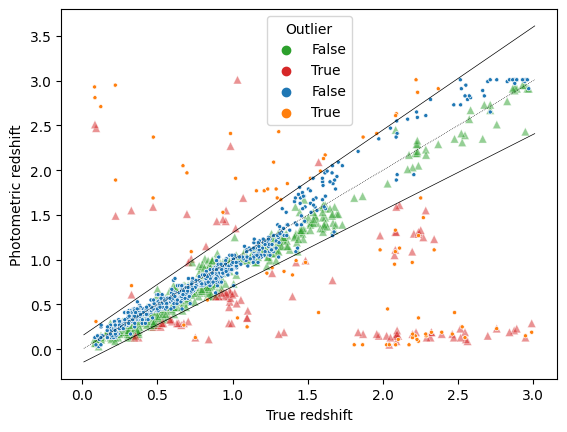

In [15]:
f,a=plt.subplots(1,1)
sns.scatterplot(data=df_test_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='^', alpha=0.5,\
                palette={True:'tab:red', False:'tab:green'}, ax=a)
sns.scatterplot(data=df_ref_more, x='True redshift', y='Photometric redshift', hue='Outlier', marker='.', ax=a)
a.plot(z_grid_ref, z_grid_ref, c='k', ls=':', lw=0.5)
a.plot(z_grid_ref, 0.15+1.15*z_grid_ref, c='k', lw=0.5)
a.plot(z_grid_ref, -0.15+0.85*z_grid_ref, c='k', lw=0.5)

In [16]:
with open(f"{ref_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_ref=pickle.load(handle)
with open(f"{test_inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict_test=pickle.load(handle)

In [17]:
_sel = (np.abs(df_test_more['Bias']) < np.abs(df_ref_more['Bias']))
sel_ref_df = df_ref_more[_sel]
sel_test_df = df_test_more[_sel]
sel_test_df

Id  Photometric redshift  True redshift   Template SED  \
0      362.0                  0.61         0.6636   CWW_Im-id546   
1     8353.0                  0.27         0.2819  CWW_Scd-id354   
3    10402.0                  0.65         0.6595   CWW_Im-id113   
4    12425.0                  1.35         1.0201  CWW_Scd-id532   
8    10103.0                  0.25         0.2636  CWW_Sbc-id451   
..       ...                   ...            ...            ...   
991  16400.0                  1.51         1.6640   CWW_Im-id107   
993  14896.0                  0.53         0.5169  CWW_Sbc-id451   
996  16455.0                  0.73         0.7336    CWW_E-id235   
998   3751.0                  0.87         0.8700   CWW_Im-id113   
999   1602.0                  1.03         1.1173   CWW_Im-id113   

    Extinction law  E(B-V)        Chi2 Highest evidence SED  \
0           Prevot    0.25   20.912914         CWW_Im-id546   
1         Calzetti    0.15  122.422340        CWW_Scd-id354   
3           Prevot    0.20   13.791986         CWW_Im-id113   
4           Prevot    0.20   23.257961        CWW_Scd-id532   
8         Calzetti    0.15   17.342867        CWW_Sbc-id451   
..             ...     ...         ...                  ...   
991         Prevot    0.10   31.225187         CWW_Im-id107   
993         Prevot    0.25    0.740293        CWW_Sbc-id451   
996       Calzetti    0.10    4.324327          CWW_E-id235   
998         Prevot    0.15   28.793911         CWW_Im-id113   
999         Prevot    0.05   14.707774         CWW_Im-id113   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                      Prevot                     0.25  ...        21.724495   
1                    Calzetti                     0.15  ...        19.593529   
3                      Prevot                     0.20  ...        22.066360   
4                      Prevot                     0.20  ...        23.027916   
8                    Calzetti                     0.15  ...        21.911652   
..                        ...                      ...  ...              ...   
991                    Prevot                     0.10  ...        22.706375   
993                    Prevot                     0.25  ...        19.990402   
996                  Calzetti                     0.10  ...        20.603783   
998                    Prevot                     0.15  ...        21.752357   
999                    Prevot                     0.05  ...        22.431557   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
3               0.007630        21.858215             0.008252   
4               0.011093        22.694069             0.011409   
8               0.005749        21.650139             0.005989   
..                   ...              ...                  ...   
991             0.008897        22.678719             0.010923   
993             0.003231        19.627701             0.003171   
996             0.003643        20.173088             0.003468   
998             0.005474        21.451469             0.005597   
999             0.007169        22.034317             0.007080   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)          Bias  Outlier       U-B  \
0         21.581612            0.007518 -5.360005e-02    False  0.455261   
1         19.226929            0.002557 -1.190002e-02    False  0.858223   
3         21.678215            0.009633 -9.500024e-03    False  0.587463   
4         22.185799            0.011367  3.298999e-01     True  0.492928   
8         21.462891            0.006606 -1.360000e-02    False  1.483040   
..              ...                 ...           ...      ...       ...   
991       22.368042            0.012502 -1.540000e-01    False  0.323280   
993       19.450676            0.003348  1.309997e-02    False  2.309647  

In [18]:
sel_ref_df

Id  Photometric redshift  True redshift        Template SED  \
0      362.0                  0.45         0.6636   Scd_cww_resample9   
1     8353.0                  0.41         0.2819  Sbc_cww_resample11   
3    10402.0                  0.61         0.6595   Scd_cww_resample0   
4    12425.0                  1.91         1.0201   Sbc_cww_resample1   
8    10103.0                  0.29         0.2636   El_cww_resample12   
..       ...                   ...            ...                 ...   
991  16400.0                  2.05         1.6640   Scd_cww_resample8   
993  14896.0                  0.47         0.5169    El_cww_resample1   
996  16455.0                  0.67         0.7336    El_cww_resample1   
998   3751.0                  0.75         0.8700   Scd_cww_resample2   
999   1602.0                  1.01         1.1173   Scd_cww_resample8   

    Extinction law  E(B-V)        Chi2  Highest evidence SED  \
0         Calzetti     0.0   47.006870     Scd_cww_resample9   
1         Calzetti     0.0  229.159592  SB2_total2_resample0   
3         Calzetti     0.0   26.461437     Scd_cww_resample0   
4         Calzetti     0.0   26.649300     Sbc_cww_resample1   
8         Calzetti     0.0   14.326860     El_cww_resample12   
..             ...     ...         ...                   ...   
991       Calzetti     0.0   57.496078     Scd_cww_resample8   
993       Calzetti     0.0   -1.704903      El_cww_resample1   
996       Calzetti     0.0   10.991859      El_cww_resample1   
998       Calzetti     0.0   59.368866     Scd_cww_resample2   
999       Calzetti     0.0   57.782326     Scd_cww_resample8   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_iHSC)  \
0                    Calzetti                      0.0  ...        21.724495   
1                    Calzetti                      0.0  ...        19.593529   
3                    Calzetti                      0.0  ...        22.066360   
4                    Calzetti                      0.0  ...        23.027916   
8                    Calzetti                      0.0  ...        21.911652   
..                        ...                      ...  ...              ...   
991                  Calzetti                      0.0  ...        22.706375   
993                  Calzetti                      0.0  ...        19.990402   
996                  Calzetti                      0.0  ...        20.603783   
998                  Calzetti                      0.0  ...        21.752357   
999                  Calzetti                      0.0  ...        22.431557   

     err_MagAB(hsc_iHSC)  MagAB(hsc_zHSC)  err_MagAB(hsc_zHSC)  \
0               0.005330        21.681114             0.006234   
1               0.002292        19.379829             0.002413   
3               0.007630        21.858215             0.008252   
4               0.011093        22.694069             0.011409   
8               0.005749        21.650139             0.005989   
..                   ...              ...                  ...   
991             0.008897        22.678719             0.010923   
993             0.003231        19.627701             0.003171   
996             0.003643        20.173088             0.003468   
998             0.005474        21.451469             0.005597   
999             0.007169        22.034317             0.007080   

    MagAB(hsc_yHSC) err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  
0         21.581612            0.007518 -0.2136    False  0.455261  0.429222  
1         19.226929            0.002557  0.1281    False  0.858223  0.419388  
3         21.678215            0.009633 -0.0495    False  0.587463  0.611992  
4         22.185799            0.011367  0.8899     True  0.492928  0.423218  
8         21.462891            0.006606  0.0264    False  1.483040  0.515427  
..              ...                 ...     ...      ...       ...       ...  
991       22.368042            0.012502  0.3860    False 

In [19]:
good_case, bad_case = 991, 4

In [20]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 most likely models'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 most likely models'])

In [21]:
good_test_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0   CWW_Im-id107    Prevot    0.1       1.51  1.5135548  0.00066237163   
1   CWW_Im-id546    Prevot    0.1  1.5699999   1.561644  0.00041982357   
2   CWW_Im-id344  Calzetti    0.2       1.53  1.5320681   0.0005542389   
3   CWW_Im-id344    Prevot    0.1       1.49  1.4805167   0.0005034405   
4  CWW_Sbc-id496    Prevot   0.15  1.4499999  1.4524919   0.0003185914   

   median(z)    Odd ratio         Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0       1.55          1.0  -0.15400004        23.202232       23.261314   
1  1.5899999    0.5986781   -0.0940001        23.195274       23.234886   
2  1.5699999    0.0269597  -0.13400006        23.208534       23.230759   
3       1.51  0.015484893  -0.17400002         23.20417       23.265175   
4       1.49  0.009055118   -0.2140001        23.212532       23.297264   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   22.951065   22.784882   22.705116   22.650436   22.396965  
1    22.94712   22.805023   22.714378    22.68325   22.417442  
2   22.951683    22.80207   22.730217   22.606293   22.411766  
3   22.896538   22.744316     22.7128    22.66964   22.480156  
4   22.919945   22.759666   22.703224   22.628716   22.365646

In [22]:
good_ref_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0   Scd_cww_resample8  Calzetti    0.0       2.05  2.0463529   0.0015267796   
1   Scd_cww_resample9  Calzetti    0.0       2.09  2.0873704   0.0015762728   
2  Scd_cww_resample10  Calzetti    0.0  2.1499999   2.137422    0.001406534   
3   Scd_cww_resample7  Calzetti    0.0       2.01  2.0140667   0.0014173791   
4    Im_cww_resample0  Calzetti    0.0       2.19  2.1821668  0.00092972134   

   median(z)     Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0       2.07           1.0  0.38599992        23.200775       23.273582   
1       2.11    0.26977938  0.42599988        23.193756       23.272568   
2  2.1699998    0.01782536  0.48599982        23.192543       23.282967   
3       2.05   0.013807314  0.34599996        23.210258       23.279266   
4       2.21  0.0009244895       0.526         23.19197       23.289635   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0    22.98294    22.79921   22.699852   22.585724   22.444038  
1    22.97374    22.79831   22.699814   22.605888   22.483887  
2   22.955849   22.791725   22.690392   22.615257   22.516174  
3    22.99112   22.800903   22.697906   22.559639   22.398659  
4    22.94075     22.7891   22.684624   22.621422   22.540352

In [23]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 most likely models'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 most likely models'])
bad_test_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0  CWW_Scd-id532    Prevot    0.2  1.3499999  1.3462647   0.0005781696   
1   CWW_Im-id113  Calzetti   0.25       1.51  1.5019174    0.000481955   
2  CWW_Scd-id639    Prevot    0.1  1.5899999  1.5912948   0.0002035626   
3   CWW_Im-id114  Calzetti   0.25       1.51  1.5023245  0.00045566444   
4  CWW_Scd-id354    Prevot    0.2       1.53   1.528439   0.0003925275   

  median(z)   Odd ratio       Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      1.37  0.99999994  0.3298999        24.328224       24.464363   
1      1.53   0.6305511     0.4899        24.314247       24.407509   
2      1.63  0.35566387  0.5698999        24.311165       24.401337   
3      1.53   0.3495353     0.4899         24.31791       24.413147   
4      1.55  0.28793234     0.5099        24.351372        24.45449   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0    23.82769   23.451576   23.040543   22.686615    22.18792  
1   23.835426   23.482986   23.032417   22.680954   22.199303  
2   23.854614   23.514442     23.0336   22.674255   22.184196  
3   23.841171   23.487755     22.9999   22.712822   22.195091  
4   23.881645   23.483261   23.007065   22.662376   22.199669

In [24]:
bad_ref_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0  Sbc_cww_resample1  Calzetti    0.0       1.91  1.9170847  0.00082262204   
1  Sbc_cww_resample0  Calzetti    0.0  1.9499999  1.9568967  0.00080249493   
2  El_cww_resample20  Calzetti    0.0  1.9699999  1.9808588  0.00084579096   
3  Sbc_cww_resample2  Calzetti    0.0       1.87   1.875566  0.00084371865   
4  El_cww_resample19  Calzetti    0.0       2.01   2.006703  0.00090503815   

   median(z)   Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0  1.9499999         1.0  0.88989997        24.314323       24.412056   
1  1.9899999   0.7593815  0.92989993        24.348244       24.449387   
2       2.01   0.4157902   0.9498999        24.356346       24.458984   
3       1.91  0.25676772      0.8499        24.286308       24.380974   
4       2.03   0.1991637      0.9899        24.361053       24.467445   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0    23.86982   23.454605   23.059998   22.659279   22.195908  
1   23.891388   23.450035   23.038078   22.651787    22.19545  
2   23.895226   23.451012   23.039146   22.645393    22.19381  
3    23.85292   23.463387   23.080673   22.663055   22.196861  
4   23.890938   23.442284   23.035583   22.641014   22.205734

In [25]:
df_test_more.columns

Index(['Id', 'Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'Highest evidence SED',
       'Highest evidence dust law', 'Highest evidence E(B-V)',
       'Highest evidence odd ratio', 'Highest evidence z_phot (mode)',
       'Highest evidence z_phot (mean)', 'Highest evidence sigma(z)',
       'Best SED at z_spec', 'Best dust law at z_spec', 'E(B-V) at z_spec',
       'Mode of best model at z_spec', 'Mean of best model at z_spec',
       'Odd ratio of best model at z_spec', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'Bias', 'Outlier', 'U-B',
       'R-I'],
      dtype='object')

<AxesSubplot:xlabel='True redshift', ylabel='Highest evidence odd ratio'>

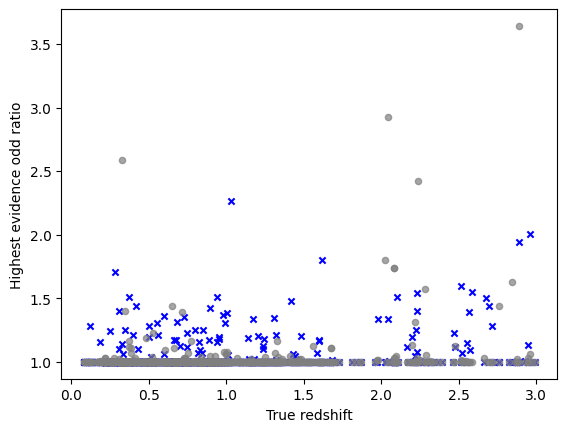

In [26]:
f,a=plt.subplots(1,1)
df_test_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='blue', marker='x', ax=a)
df_ref_more.plot.scatter('True redshift', 'Highest evidence odd ratio', c='grey', alpha=0.7, ax=a)

In [27]:
def zp_zs_plot(photo_z_df, x_series, y_series, outlier_lim_pct=15, hue=None):
    f,a=plt.subplots(1,1)
    if hue is None:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series]].copy()
        hue='outlier'
    else:
        df_to_plot = photo_z_df[[photo_z_df.columns[0], x_series, y_series, hue]].copy()
    df_to_plot['bias'] = df_to_plot[y_series]-df_to_plot[x_series]
    df_to_plot['scatter'] = np.abs(df_to_plot['bias']/(1.+df_to_plot[x_series]))
    df_to_plot['outlier'] = (df_to_plot['scatter'] > outlier_lim_pct/100)
    outl_rate = 100.0*len(df_to_plot[df_to_plot['outlier']])/len(df_to_plot)
    
    med = np.median(df_to_plot[x_series])
    resids = np.abs(df_to_plot[y_series] - med)
    
    NMAD = 1.4826 * np.median(df_to_plot['scatter'])

    sns.scatterplot(data=df_to_plot, x=x_series, y=y_series, hue=hue, marker='.', ax=a)
    a.plot(df_to_plot[x_series].values, df_to_plot[x_series].values, c='k', ls=':', lw=0.5)
    a.plot(df_to_plot[x_series].values, outlier_lim_pct/100+(1.+outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.plot(df_to_plot[x_series].values, -outlier_lim_pct/100+(1.-outlier_lim_pct/100)*df_to_plot[x_series].values, c='k', lw=0.5)
    a.set_title("$z_{phot}$ vs. $z_{spec}$ : "+f"{outl_rate:.3f}% outliers @{outlier_lim_pct}% ; NMAD={NMAD:.4f}")
    
def which_is_best(photo_z_df):
    poss_src = np.array(['Photometric redshift', 'Highest evidence z_phot (mode)', 'Highest evidence z_phot (mean)'])
    bias_mode = np.abs(photo_z_df['Bias'].values)
    bias_ev_mode = np.abs(photo_z_df['Highest evidence z_phot (mode)'].values - photo_z_df['True redshift'].values)
    bias_ev_mean = np.abs(photo_z_df['Highest evidence z_phot (mean)'].values - photo_z_df['True redshift'].values)
    
    best_pestim = []
    for m, ev_mo, ev_me in zip(bias_mode, bias_ev_mode, bias_ev_mean):
        order = np.argsort([m, ev_mo, ev_me])
        sorted_es = poss_src[order]
        best_pestim.append(sorted_es[0])
        '''
        if ev_me<ev_mo and ev_me<m :
            best_pestim.append('Highest evidence z_phot (mean)')
        elif ev_mo<m and ev_mo<ev_me :
            best_pestim.append('Highest evidence z_phot (mode)')
        else :
            assert (m<=ev_mo and m<=ev_me), "Error in logic."
            best_pestim.append('Photometric redshift')
        '''
                
    best_zp = np.array([ photo_z_df.loc[photo_z_df.index[n], esti] for n,esti in enumerate(best_pestim) ])
    
    photo_z_df['Best estimator']=np.array(best_pestim)
    photo_z_df['Best point estimate']=best_zp
    zp_zs_plot(photo_z_df, 'True redshift', 'Best point estimate', hue='Best estimator')
    

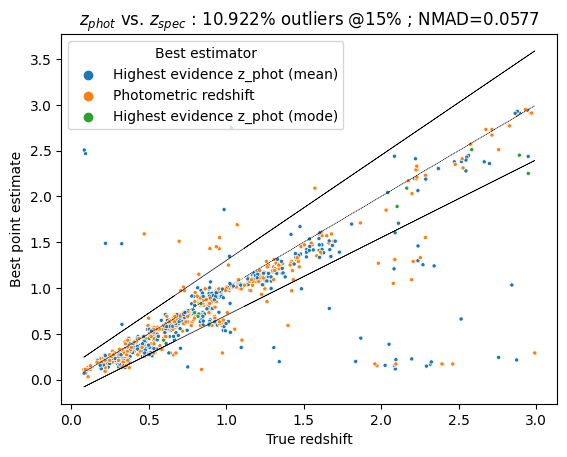

In [28]:
which_is_best(df_test_more)

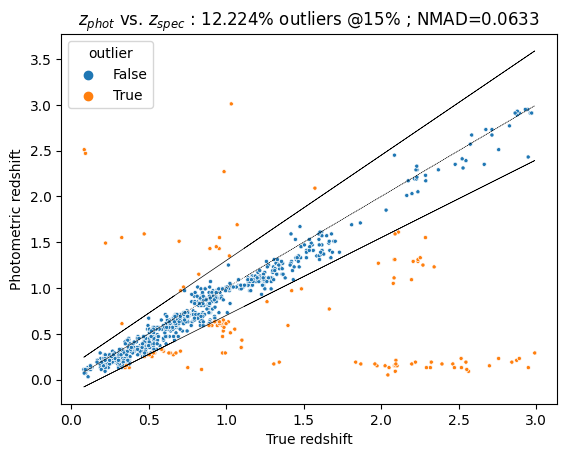

In [29]:
zp_zs_plot(df_test_more, 'True redshift', 'Photometric redshift')

In [30]:
bad_test_df = pd.DataFrame(posteriors_dict_test[bad_case]['5 best models at z_spec'])
bad_ref_df = pd.DataFrame(posteriors_dict_ref[bad_case]['5 best models at z_spec'])
bad_test_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0   CWW_Im-id344    Prevot   0.25       0.77  0.9267508     0.01873813   
1   CWW_Im-id344    Prevot    0.3  1.0899999  1.0959537  0.00069922104   
2   CWW_Im-id344  Calzetti    0.4  1.2099999  1.1913631   0.0024188447   
3   CWW_Im-id344  Calzetti   0.35       1.03   1.036323  0.00056717545   
4  CWW_Scd-id532    Prevot   0.15  1.0699999  1.0776763  0.00072922173   

   median(z)      Odd ratio         Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0       1.03   5.752638e-09  -0.25010002        24.268982       24.373337   
1       1.13  4.7223822e-11   0.06989992        24.492966       24.618828   
2       1.23    6.85939e-09   0.18989992        24.327415       24.408928   
3  1.0699999   7.501883e-15  0.009899974         24.18312       24.254074   
4       1.11   5.906493e-15  0.049899936        24.247353       24.309929   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   23.765465   23.420898   23.102646   22.614418   22.338844  
1   23.873383   23.432373    23.06723   22.542229   22.245651  
2   23.966667   23.624474   23.111198   22.536743   22.193031  
3   23.876396   23.596115   23.136597   22.595695   22.273643  
4   23.975792   23.647835   23.123268    22.53872   22.245438

Text(0, 0.5, '$p(z \\cap model)$')

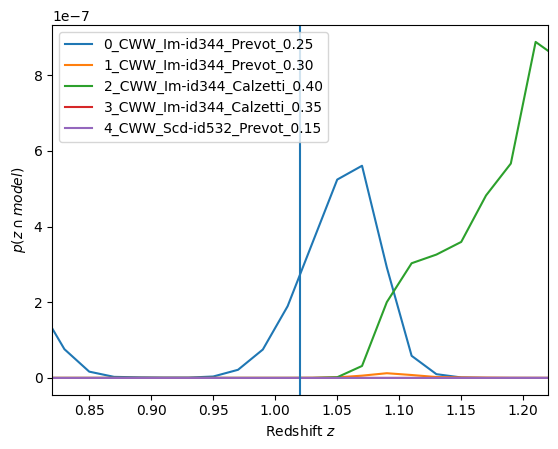

In [31]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[bad_case]['Full posterior']
for item in bad_test_df.index :
    mod_num=np.argwhere(temp_names == bad_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==bad_test_df.loc[item, 'Dust law'] and d.EBV==bad_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-bad_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    #print(temp_names[mod_num])
    #print(dust_arr_test[dust_num])
    #print(z_grid_test[z_num])
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{bad_test_df.loc[item, 'Template SED']}_{bad_test_df.loc[item, 'Dust law']}_{bad_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[bad_case, "True redshift"])
plt.xlim(df_test_more.loc[bad_case, "True redshift"]-0.2, df_test_more.loc[bad_case, "True redshift"]+0.2)
#plt.ylim(1.e-6, 1.e3)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z \cap model)$")
#plt.yscale('log')

In [32]:
good_test_df = pd.DataFrame(posteriors_dict_test[good_case]['5 best models at z_spec'])
good_ref_df = pd.DataFrame(posteriors_dict_ref[good_case]['5 best models at z_spec'])
good_test_df

Template SED  Dust law E(B-V)  zp (mode) average(z)       sigma(z)  \
0  CWW_Im-id546    Prevot    0.1  1.5699999   1.561644  0.00041982357   
1  CWW_Im-id107    Prevot    0.1       1.51  1.5135548  0.00066237163   
2  CWW_Im-id107  Calzetti    0.2  1.5899999  1.5867634  0.00068560883   
3  CWW_Im-id537    Prevot    0.1       1.63   1.636115  0.00038790054   
4  CWW_Im-id265  Calzetti   0.25       1.65   1.656332   0.0009627893   

   median(z)      Odd ratio          Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0  1.5899999      0.5986781    -0.0940001        23.193207       23.257729   
1       1.55            1.0   -0.15400004        23.212868       23.274841   
2  1.6099999  1.6924823e-05   -0.07400012        23.191582       23.223114   
3       1.67  3.0612392e-07   -0.03400004        23.199097        23.27108   
4  1.6899999  3.2390442e-08  -0.014000058        23.204765       23.249382   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0     22.9441   22.786797   22.686974   22.656342   22.536278  
1   22.949074   22.756004   22.657906    22.61164    22.53318  
2   23.010574   22.839333   22.718582    22.60868   22.465706  
3   22.982239   22.851486   22.700684   22.574821   22.402634  
4   23.011337    22.84629   22.701653    22.57315   22.384224

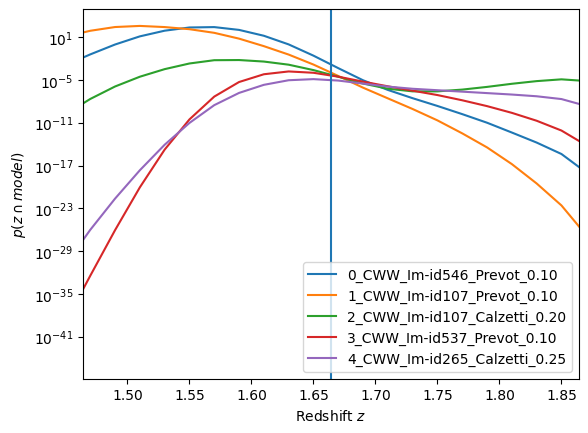

In [33]:
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
posterior = posteriors_dict_test[good_case]['Full posterior']
for item in good_test_df.index :
    mod_num=np.argwhere(temp_names == good_test_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[item, 'Dust law'] and d.EBV==good_test_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[item, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    plt.plot(z_grid_test, posterior[mod_num, dust_num, :],\
             label=f"{item}_{good_test_df.loc[item, 'Template SED']}_{good_test_df.loc[item, 'Dust law']}_{good_test_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_test_more.loc[good_case, "True redshift"])
plt.xlim(df_test_more.loc[good_case, "True redshift"]-0.2, df_test_more.loc[good_case, "True redshift"]+0.2)
#plt.ylim(1.e-9, 1.e3)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z \cap model)$")
plt.yscale('log')

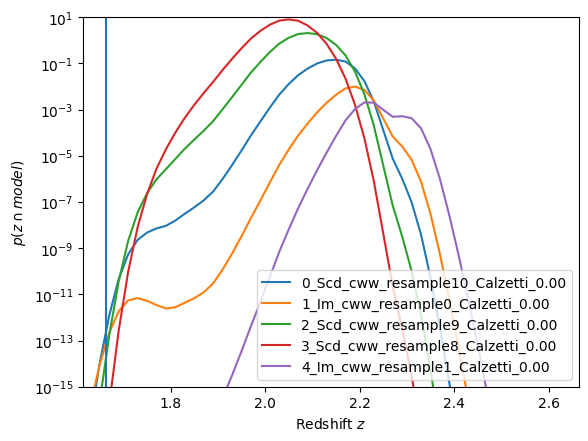

In [34]:
temp_names = np.array([ref_inputs['Templates'][t]['name'] for t in ref_inputs['Templates']])
posterior = posteriors_dict_ref[good_case]['Full posterior']
for item in good_ref_df.index :
    mod_num=np.argwhere(temp_names == good_ref_df.loc[item, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_ref):
        if d.name==good_ref_df.loc[item, 'Dust law'] and d.EBV==good_ref_df.loc[item, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_ref-good_ref_df.loc[item, 'zp (mode)'])<ref_inputs['Z_GRID']['z_step']/10)[0][0]
    plt.plot(z_grid_ref, posterior[mod_num, dust_num, :],\
             label=f"{item}_{good_ref_df.loc[item, 'Template SED']}_{good_ref_df.loc[item, 'Dust law']}_{good_ref_df.loc[item, 'E(B-V)']:.2f}")
plt.axvline(df_ref_more.loc[good_case, "True redshift"])
plt.xlim(df_ref_more.loc[good_case, "True redshift"]-0.05, df_ref_more.loc[good_case, "True redshift"]+1.)
plt.ylim(1.e-15, 1.e1)
plt.legend()
plt.xlabel("Redshift $z$")
plt.ylabel("$p(z \cap model)$")
plt.yscale('log')

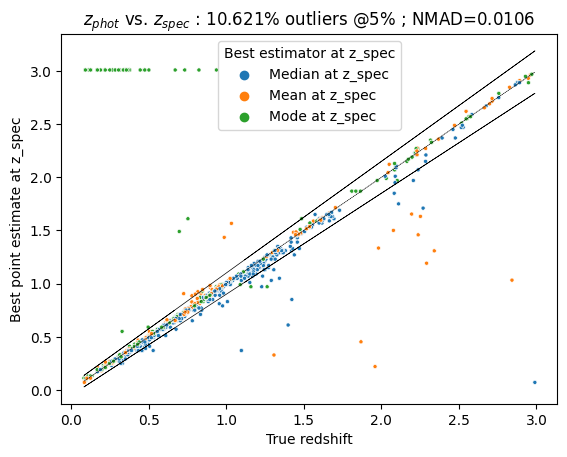

In [35]:
modes_zs = []
means_zs = []
meds_zs = []
best_estim_at_zs = []
best_zp_at_zs = []
temp_names = np.array([test_inputs['Templates'][t]['name'] for t in test_inputs['Templates']])
for loc, _case in enumerate(df_test_more.index):
    posterior = posteriors_dict_test[_case]['Full posterior']
    good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])
    
    mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    mode_at_zs = good_test_df.loc[0, 'zp (mode)']
    mean_at_zs = good_test_df.loc[0, 'average(z)']
    med_at_zs = good_test_df.loc[0, 'median(z)']
    tru_z = df_test_more.loc[_case, "True redshift"]
    
    poss_zp = np.array([mode_at_zs, mean_at_zs, med_at_zs])
    
    bias_mode = np.abs(mode_at_zs-tru_z)
    bias_mean = np.abs(mean_at_zs-tru_z)
    try :
        bias_med = np.abs(med_at_zs-tru_z)
    except TypeError:
        bias_med = 99
    
    poss_src = np.array(['Mode at z_spec', 'Mean at z_spec', 'Median at z_spec'])
    
    best_pestim = []

    order = np.argsort([bias_mode, bias_mean, bias_med])
    sorted_es = poss_src[order]
    sorted_zp = poss_zp[order]
    best_estim_at_zs.append(sorted_es[0])
    best_zp_at_zs.append(sorted_zp[0])
    
df_test_more['Best estimator at z_spec']=np.array(best_estim_at_zs)
df_test_more['Best point estimate at z_spec']=np.array(best_zp_at_zs)
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

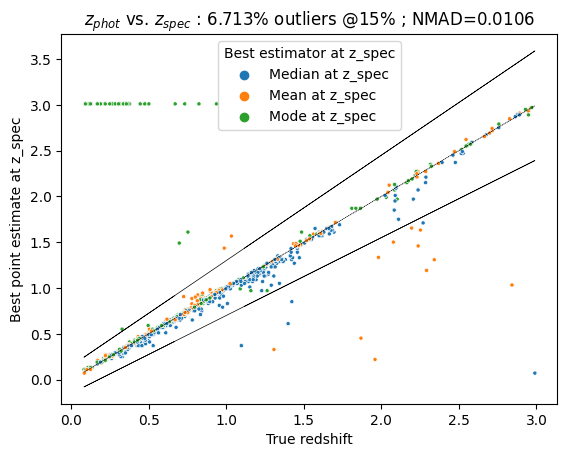

In [36]:
zp_zs_plot(df_test_more, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=15, hue='Best estimator at z_spec')

## Z-spec models study

<AxesSubplot:xlabel='Odd ratio of best model at z_spec', ylabel='Count'>

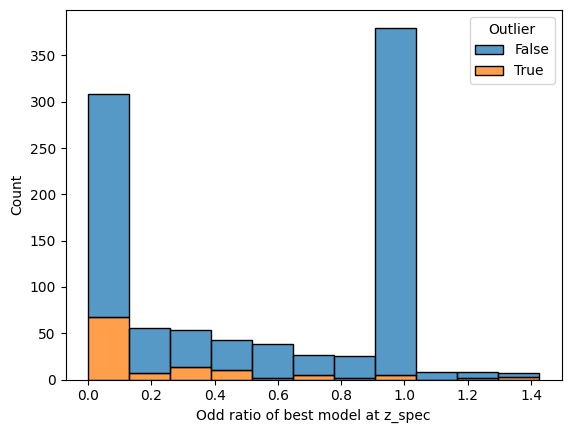

In [37]:
sns.histplot(data=df_test_more, x='Odd ratio of best model at z_spec', hue='Outlier', stat='count', multiple='stack')

In [38]:
len(np.unique(df_test_more['Best SED at z_spec'].values))

23

In [39]:
len(np.unique(df_test_more['Template SED'].values))

24

Not many templates are rejected during the run. Too bad !

In [40]:
np.nanmean(df_test_more['Odd ratio of best model at z_spec'].values)

0.549041009432279

In [41]:
sub_df = df_test_more[np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]
len(sub_df)

954

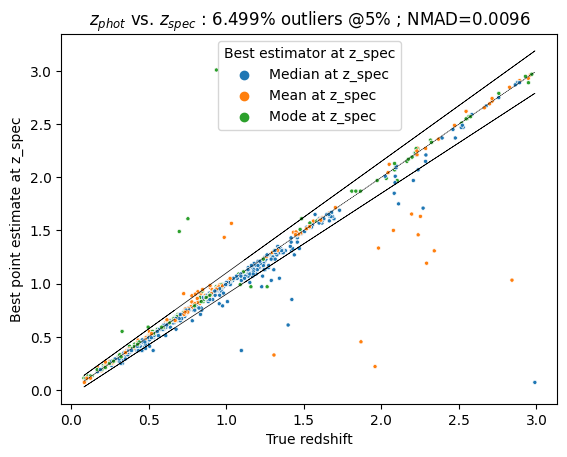

In [42]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

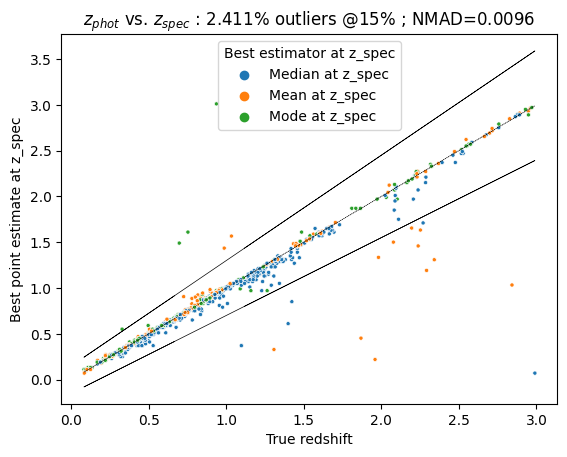

In [43]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', hue='Best estimator at z_spec')

In [44]:
np.mean(sub_df['Odd ratio of best model at z_spec'].values)

0.549041009432279

In [45]:
np.median(sub_df['Odd ratio of best model at z_spec'].values)

0.587372213602066

<AxesSubplot:xlabel='Odd ratio of best model at z_spec', ylabel='Count'>

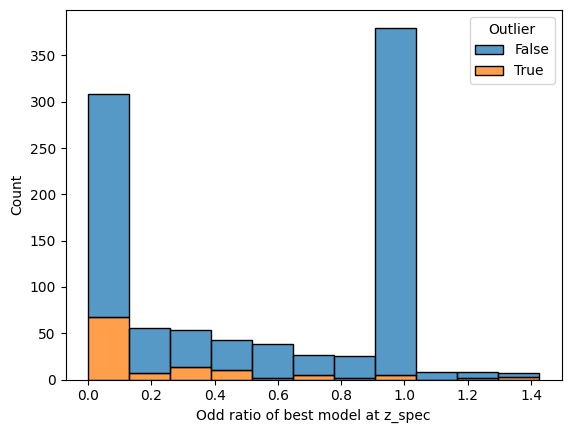

In [46]:
sns.histplot(data=sub_df, x='Odd ratio of best model at z_spec', hue='Outlier', stat='count', multiple='stack')

In [47]:
sub_df = df_test_more[[not b for b in np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]]
len(sub_df)

44

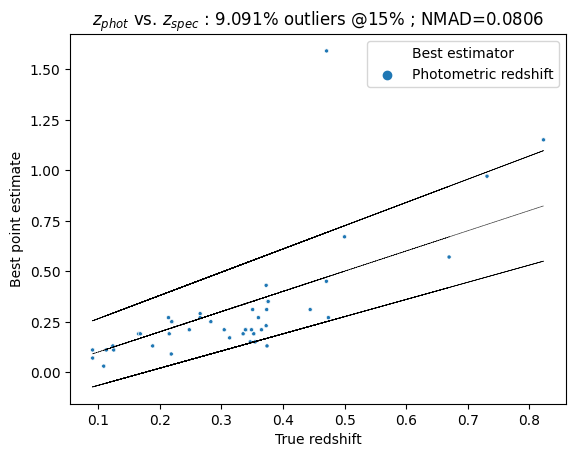

In [48]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate', hue='Best estimator')

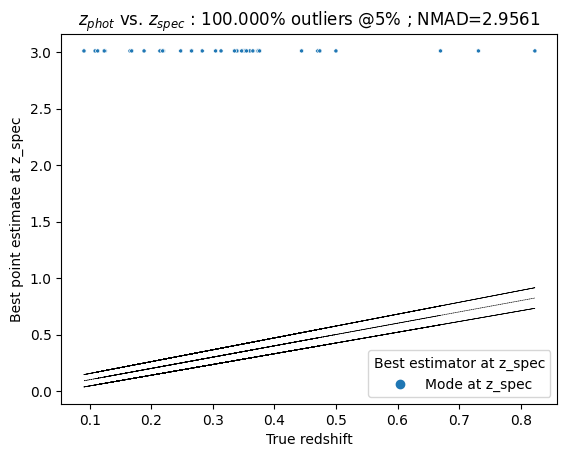

In [49]:
zp_zs_plot(sub_df, 'True redshift', 'Best point estimate at z_spec', outlier_lim_pct=5, hue='Best estimator at z_spec')

In [50]:
sub_df[[c for c in sub_df.columns if 'evidence' in c]]

Highest evidence SED Highest evidence dust law  Highest evidence E(B-V)  \
34         CWW_Scd-id585                    Prevot                      0.5   
48         CWW_Scd-id585                    Prevot                      0.5   
113        CWW_Scd-id585                    Prevot                      0.5   
115        CWW_Scd-id585                    Prevot                      0.5   
154        CWW_Scd-id585                    Prevot                      0.5   
157        CWW_Scd-id585                    Prevot                      0.5   
174        CWW_Scd-id585                    Prevot                      0.5   
188        CWW_Scd-id585                    Prevot                      0.5   
195        CWW_Scd-id585                    Prevot                      0.5   
204        CWW_Scd-id585                    Prevot                      0.5   
253        CWW_Scd-id585                    Prevot                      0.5   
276        CWW_Scd-id585                    Prevot                      0.5   
281        CWW_Scd-id585                    Prevot                      0.5   
289        CWW_Scd-id585                    Prevot                      0.5   
296        CWW_Scd-id585                    Prevot                      0.5   
330        CWW_Scd-id585                    Prevot                      0.5   
331        CWW_Scd-id585                    Prevot                      0.5   
338        CWW_Scd-id585                    Prevot                      0.5   
370        CWW_Scd-id585                    Prevot                      0.5   
375        CWW_Scd-id585                    Prevot                      0.5   
385        CWW_Scd-id585                    Prevot                      0.5   
413        CWW_Scd-id585                    Prevot                      0.5   
415        CWW_Scd-id585                    Prevot                      0.5   
423        CWW_Scd-id585                    Prevot                      0.5   
442        CWW_Scd-id585                    Prevot                      0.5   
511        CWW_Scd-id585                    Prevot                      0.5   
541        CWW_Scd-id585                    Prevot                      0.5   
667        CWW_Scd-id585                    Prevot                      0.5   
713        CWW_Scd-id585                    Prevot                      0.5   
736        CWW_Scd-id585                    Prevot                      0.5   
738        CWW_Scd-id585                    Prevot                      0.5   
766        CWW_Scd-id585                    Prevot                      0.5   
771        CWW_Scd-id585                    Prevot                      0.5   
801        CWW_Scd-id585                    Prevot                      0.5   
829        CWW_Scd-id585                    Prevot                      0.5   
831        CWW_Scd-id585                    Prevot                      0.5   
868        CWW_Scd-id585                    Prevot                      0.5   
878        CWW_Scd-id585                    Prevot                      0.5   
892        CWW_Scd-id585                    Prevot                      0.5   
927        CWW_Scd-id585                    Prevot                      0.5   
932        CWW_Scd-id585                    Prevot                      0.5   
940        CWW_Scd-id585                    Prevot                      0.5   
974        CWW_Scd-id585                    Prevot                      0.5   
976        CWW_Scd-id585                    Prevot                      0.5   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
34                          NaN                            3.01   
48                          NaN                            3.01   
113                         NaN                            3.01   
115                         NaN                            3.01   
154                         NaN                            3.01   
157                         NaN               

In [51]:
id_zarbi=34
posterior = posteriors_dict_test[id_zarbi]['Full posterior']
zarbi_df_zs = pd.DataFrame(posteriors_dict_test[id_zarbi]['5 best models at z_spec'])
zarbi_df_ev = pd.DataFrame(posteriors_dict_test[id_zarbi]['5 most likely models'])

In [52]:
zarbi_df_zs

Template SED Dust law E(B-V) zp (mode) average(z) sigma(z) median(z)  \
0  CWW_Scd-id585   Prevot    0.5      3.01        nan      nan      None   
1  CWW_Scd-id585   Prevot    0.4      3.01        nan      nan      None   
2  CWW_Scd-id585   Prevot   0.35      3.01        nan      nan      None   
3  CWW_Scd-id585   Prevot    0.3      3.01        nan      nan      None   
4  CWW_Scd-id585   Prevot   0.25      3.01        nan      nan      None   

  Odd ratio    Bias M(cosmos_u_cfht) M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC)  \
0       nan  2.9192         21.12458       21.432816   19.427605   18.766327   
1       nan  2.9192        20.983788       21.269379   19.394363   18.819237   
2       nan  2.9192         20.92714        21.20169   19.391403   18.859749   
3       nan  2.9192        20.880028       21.143707   19.397903    18.90998   
4       nan  2.9192        20.842407        21.09539   19.413834   18.969894   

  M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   18.465553   18.215141    18.04264  
1   18.558296   18.338448    18.18885  
2   18.618752   18.414207   18.276062  
3   18.688957   18.499748   18.373032  
4   18.768867   18.595009   18.479721

In [53]:
zarbi_df_ev

Template SED Dust law E(B-V) zp (mode) average(z) sigma(z) median(z)  \
0  CWW_Scd-id585   Prevot    0.5      3.01        nan      nan      None   
1  CWW_Scd-id585   Prevot    0.4      3.01        nan      nan      None   
2  CWW_Scd-id585   Prevot   0.35      3.01        nan      nan      None   
3  CWW_Scd-id585   Prevot    0.3      3.01        nan      nan      None   
4  CWW_Scd-id585   Prevot   0.25      3.01        nan      nan      None   

  Odd ratio    Bias M(cosmos_u_cfht) M(cosmos_u_new) M(hsc_gHSC) M(hsc_rHSC)  \
0       nan  2.9192        31.269493       33.291855   25.384804   20.965752   
1       nan  2.9192        30.199806       31.829529   24.607277   20.571686   
2       nan  2.9192        29.650772       31.105293   24.224945   20.379807   
3       nan  2.9192        29.092117       30.386353   23.847496   20.191917   
4       nan  2.9192        28.524185        29.67318    23.47538    20.00843   

  M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0    18.84655   18.014206    17.61274  
1   18.666473     17.9692     17.6708  
2   18.583351   17.954025   17.707344  
3   18.505478   17.944397   17.749573  
4   18.433372   17.940842    17.79802

In [54]:
sub_df = df_test_more[np.isfinite(df_test_more['Odd ratio of best model at z_spec'].values)]

In [55]:
sub_df[[c for c in sub_df.columns if 'evidence' in c]]

Highest evidence SED Highest evidence dust law  Highest evidence E(B-V)  \
0           CWW_Im-id546                    Prevot                     0.25   
1          CWW_Scd-id354                  Calzetti                     0.15   
2           CWW_Im-id537                    Prevot                     0.20   
3           CWW_Im-id113                    Prevot                     0.20   
4          CWW_Scd-id532                    Prevot                     0.20   
..                   ...                       ...                      ...   
995         CWW_Im-id265                    Prevot                     0.10   
996          CWW_E-id235                  Calzetti                     0.10   
997        CWW_Scd-id268                    Prevot                     0.05   
998         CWW_Im-id113                    Prevot                     0.15   
999         CWW_Im-id113                    Prevot                     0.05   

     Highest evidence odd ratio  Highest evidence z_phot (mode)  \
0                           1.0                            0.61   
1                           1.0                            0.27   
2                           1.0                            0.21   
3                           1.0                            0.65   
4                           1.0                            1.35   
..                          ...                             ...   
995                         1.0                            2.35   
996                         1.0                            0.73   
997                         1.0                            0.63   
998                         1.0                            0.87   
999                         1.0                            1.03   

     Highest evidence z_phot (mean)  Highest evidence sigma(z)  
0                          0.613186                   0.000299  
1                          0.269855                   0.000003  
2                          0.211476                   0.000032  
3                          0.644358                   0.000396  
4                          1.346265                   0.000578  
..                              ...                        ...  
995                        2.377516                   0.003181  
996                        0.731324                   0.000025  
997                        0.630096                   0.000112  
998                        0.859542                   0.000266  
999                        1.023042                   0.000239  

[954 rows x 7 columns]

<AxesSubplot:xlabel='Highest evidence odd ratio', ylabel='Count'>

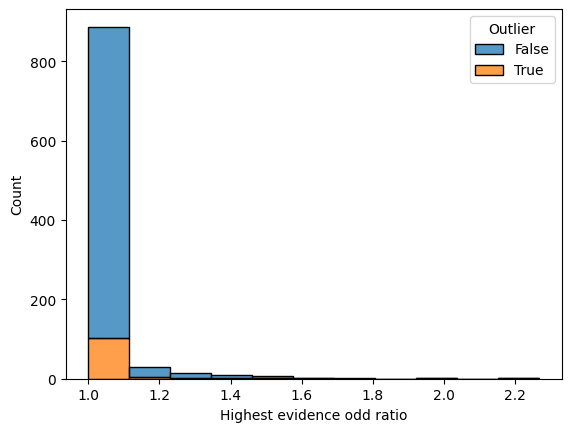

In [56]:
sns.histplot(data=sub_df, x='Highest evidence odd ratio', hue='Outlier', stat='count', multiple='stack')

In [57]:
id_test_pointEst=15
posterior = posteriors_dict_test[id_test_pointEst]['Full posterior']
pointEst_df_ev = pd.DataFrame(posteriors_dict_test[id_test_pointEst]['5 most likely models'])
pointEst_df_ev

Template SED  Dust law E(B-V)  zp (mode)  average(z)      sigma(z)  \
0    CWW_Im-id87  Calzetti   0.05  2.4299998   2.4104896   0.004036906   
1    CWW_Im-id87    Prevot   0.05       2.23   2.2375083  0.0022599483   
2  CWW_Scd-id639    Prevot    0.0       0.19  0.30464596    0.29846308   
3  CWW_Scd-id639  Calzetti    0.0       0.19  0.30464596    0.29846308   
4   CWW_Im-id107    Prevot    0.1       2.55   2.5261943   0.006540905   

  median(z)   Odd ratio        Bias M(cosmos_u_cfht) M(cosmos_u_new)  \
0      2.45   1.0449785  0.20969987        25.832176       26.011635   
1      2.27   1.0349127  0.00970006          25.7313       26.194534   
2      0.23         1.0     -2.0303        25.736618        25.83657   
3      0.23         1.0     -2.0303        25.736618        25.83657   
4      2.57  0.49476022      0.3297        25.734001       25.962059   

  M(hsc_gHSC) M(hsc_rHSC) M(hsc_iHSC) M(hsc_zHSC) M(hsc_yHSC)  
0   24.746834   24.427834   24.302162   24.224663   24.120918  
1   24.809189   24.450676   24.331703     24.1604   24.009377  
2   24.832664   24.425087   24.288857   24.207024   24.160973  
3   24.832664   24.425087   24.288857   24.207024   24.160973  
4   24.847298   24.449081   24.264473   24.198257   24.143784

In [58]:
def weighted_point_est(true_z, a,b,c):
    a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    return bias

In [59]:
weighted_point_est(sub_df.loc[id_test_pointEst, 'True redshift'], 1,1,1)

0.55167556

In [60]:
sub_df.loc[id_test_pointEst, 'Bias']

-2.0303000023841857

In [61]:
sub_sub_df = sub_df[sub_df['Highest evidence odd ratio'] > 1.]
sub_sub_df

Id  Photometric redshift  True redshift   Template SED  \
14    1846.0                  0.63         0.6850    CWW_E-id282   
15    6568.0                  0.19         2.2203  CWW_Scd-id639   
20    5992.0                  0.27         0.6585  CWW_Scd-id268   
36    8404.0                  0.71         0.7470   CWW_Im-id113   
39    9697.0                  0.45         0.5325   CWW_Im-id114   
..       ...                   ...            ...            ...   
959   9944.0                  2.33         2.2290   CWW_Im-id546   
969  13446.0                  0.65         0.7308   CWW_Scd-id45   
984  10879.0                  0.29         0.1868  CWW_Scd-id639   
990  11291.0                  2.95         2.9290   CWW_Im-id546   
994   3065.0                  0.23         2.8903  CWW_Scd-id585   

    Extinction law  E(B-V)       Chi2 Highest evidence SED  \
14        Calzetti    0.20   8.044220        CWW_Sbc-id451   
15        Calzetti    0.00  26.027418          CWW_Im-id87   
20        Calzetti    0.25  22.887430        CWW_Scd-id268   
36          Prevot    0.05  19.340179         CWW_Im-id113   
39        Calzetti    0.05  19.384127         CWW_Im-id114   
..             ...     ...        ...                  ...   
959         Prevot    0.05  25.973288         CWW_Im-id699   
969       Calzetti    0.40  28.137486        CWW_Scd-id639   
984       Calzetti    0.00  22.638868        CWW_Scd-id354   
990         Prevot    0.05  27.817621         CWW_Im-id107   
994       Calzetti    0.00  28.171988          CWW_Im-id87   

    Highest evidence dust law  Highest evidence E(B-V)  ...  MagAB(hsc_yHSC)  \
14                   Calzetti                     0.20  ...        20.964348   
15                   Calzetti                     0.05  ...        24.110420   
20                   Calzetti                     0.25  ...        20.380989   
36                   Calzetti                     0.05  ...        21.868515   
39                   Calzetti                     0.05  ...        21.728256   
..                        ...                      ...  ...              ...   
959                  Calzetti                     0.20  ...        24.406013   
969                  Calzetti                     0.50  ...        21.192474   
984                    Prevot                     0.00  ...        23.573334   
990                    Prevot                     0.05  ...        24.073059   
994                    Prevot                     0.05  ...        24.181839   

     err_MagAB(hsc_yHSC)    Bias  Outlier       U-B       R-I  \
14              0.005703 -0.0550    False  1.632057  1.166130   
15              0.039643 -2.0303     True  1.248039  0.118515   
20              0.004934 -0.3885     True       NaN  0.675446   
36              0.010529 -0.0370    False  0.167320  0.528297   
39              0.009276 -0.0825    False  0.261444  0.318024   
..                   ...     ...      ...       ...       ...   
959             0.048626  0.1010    False  0.575539  0.043915   
969             0.005955 -0.0808    False  1.220024  1.136635   
984             0.025228  0.1032    False  0.923431  0.239784   
990             0.039745  0.0210    False  1.496895  0.072495   
994             0.042466 -2.6603     True  1.238106  0.170616   

                     Best estimator  Best point estimate  \
14   Highest evidence z_phot (mean)             0.682500   
15   Highest evidence z_phot (mean)             2.410490   
20             Photometric redshift             0.270000   
36             Photometric redshift             0.710000   
39   Highest evidence z_phot (mean)             0.450683   
..                              ...                  ...   
959            Photometric redshift             2.330000   
969  Highest evidence z_phot (mean)             0.679092   
984  Highest evidence z_phot (mean)             0.155746   
990            Photometric redshift             2.950000   
994  Highest evidence z_phot (mode)           

In [62]:
from scipy.optimize import curve_fit

y_data = np.abs(sub_df['Best point estimate at z_spec'].values - sub_df['True redshift'].values)
x_data = np.array(sub_df.index)

def get_odd_ratios(xx, rank):
    odd_rat = []
    for x in xx :
        pointEst_df_ev = pd.DataFrame(posteriors_dict_test[x]['5 most likely models'])
        odd_rat.append(pointEst_df_ev.loc[rank, 'Odd ratio'])
    return np.array(odd_rat)

def get_avg_z(xx, rank):
    avg_z = []
    for x in xx :
        pointEst_df_ev = pd.DataFrame(posteriors_dict_test[x]['5 most likely models'])
        avg_z.append(pointEst_df_ev.loc[rank, 'average(z)'])
    return np.array(avg_z)

a_vals, b_vals, c_vals = get_odd_ratios(x_data, 0), get_odd_ratios(x_data, 1), get_odd_ratios(x_data, 2)
z1_vals, z2_vals, z3_vals = get_avg_z(x_data, 0), get_avg_z(x_data, 1), get_avg_z(x_data, 2)

In [63]:
def weighted_point_est(idx:int, a,b,c):
    true_z = sub_df.loc[idx, 'True redshift']
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[int(idx[0])]['5 most likely models'])
    a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    return bias

res = curve_fit(weighted_point_est, x_data, y_data, p0=(1.,1.,1.))
res

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([1., 1., 1.]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

Optimization by this means fails. May be a minimize?

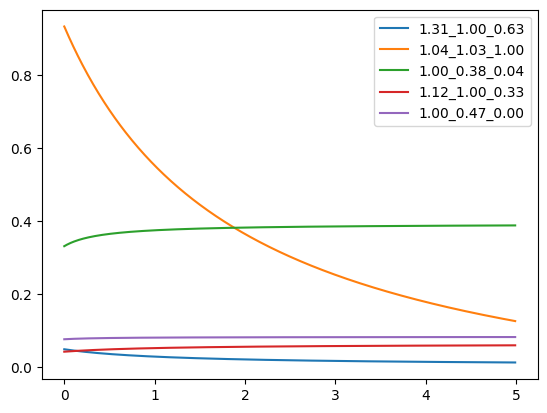

In [64]:
from scipy.optimize import minimize
x_data = np.array(sub_sub_df.index)
alist=np.arange(0., 5., 0.01)
for idx in x_data[:5]:
    true_z = sub_df.loc[idx, 'True redshift']
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[idx]['5 most likely models'])
    
    def weighted_point_est(abc):
        a,b,c = abc
        a1 = a*pointEst_df_ev.loc[0, 'Odd ratio']
        b1 = b*pointEst_df_ev.loc[1, 'Odd ratio']
        c1 = c*pointEst_df_ev.loc[2, 'Odd ratio']
        z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
        bias = np.abs(true_z-z_pointEst)
        return bias
    
    #res = minimize(weighted_point_est, (1.,1.,1.))
    #print(res)
    
    biases = [weighted_point_est((a,1.,1.)) for a in alist]
    
    plt.plot(alist, biases, label=f"{pointEst_df_ev.loc[0, 'Odd ratio']:.2f}_{pointEst_df_ev.loc[1, 'Odd ratio']:.2f}_{pointEst_df_ev.loc[2, 'Odd ratio']:.2f}")
plt.legend()

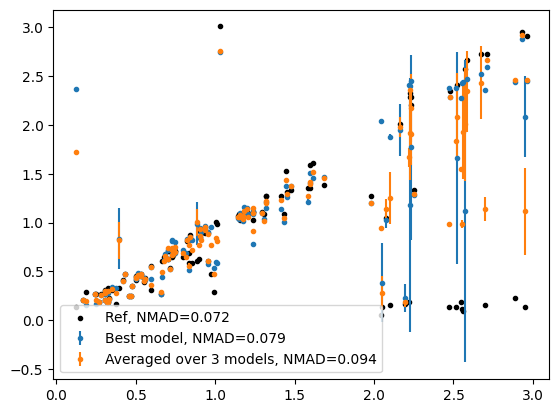

In [65]:
new_pe_z = []
new_pe_sig = []
best_mod_pe = []
best_mod_sig = []
for idx in x_data:
    pointEst_df_ev = pd.DataFrame(posteriors_dict_test[idx]['5 most likely models'])
    a1 = pointEst_df_ev.loc[0, 'Odd ratio']
    b1 = pointEst_df_ev.loc[1, 'Odd ratio']
    c1 = pointEst_df_ev.loc[2, 'Odd ratio']
    z_pointEst = (a1*pointEst_df_ev.loc[0, 'average(z)'] + b1*pointEst_df_ev.loc[1, 'average(z)'] + c1*pointEst_df_ev.loc[2, 'average(z)'])/(a1+b1+c1)
    bias = np.abs(true_z-z_pointEst)
    
    var_pointEst = np.power(a1*pointEst_df_ev.loc[0, 'sigma(z)']/(a1+b1+c1), 2.)\
                    + np.power(b1*pointEst_df_ev.loc[1, 'sigma(z)']/(a1+b1+c1), 2.)\
                    + np.power(c1*pointEst_df_ev.loc[2, 'sigma(z)']/(a1+b1+c1), 2.)
    
    best_mod_pe.append(pointEst_df_ev.loc[0, 'average(z)'])
    best_mod_sig.append(pointEst_df_ev.loc[0, 'sigma(z)'])
    
    new_pe_z.append(z_pointEst)
    new_pe_sig.append(var_pointEst**0.5)

med = np.median(sub_sub_df['True redshift'].values)    

scat_ref = np.abs(sub_sub_df['Photometric redshift'].values-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)
scat_bm = np.abs(best_mod_pe-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)
scat_npe = np.abs(new_pe_z-sub_sub_df['True redshift'].values)/(1+sub_sub_df['True redshift'].values)

NMAD_ref = 1.4826 * np.median(scat_ref)
NMAD_bm = 1.4826 * np.median(scat_bm)
NMAD_npe = 1.4826 * np.median(scat_npe)

plt.scatter(sub_sub_df['True redshift'].values, sub_sub_df['Photometric redshift'].values, marker=".", c='k', label=f"Ref, NMAD={NMAD_ref:.3f}")
plt.errorbar(sub_sub_df['True redshift'].values, best_mod_pe, yerr=best_mod_sig, fmt=".", label=f"Best model, NMAD={NMAD_bm:.3f}")
plt.errorbar(sub_sub_df['True redshift'].values, new_pe_z, yerr=new_pe_sig, fmt=".", label=f"Averaged over 3 models, NMAD={NMAD_npe:.3f}")
plt.legend()

## Rank of best model at $z_{spec}$

### Re-compute the evidences

In [66]:
# Include evidence-derived properties
_case = id_test_pointEst
probsarr = posteriors_dict_test[_case]['Full posterior']
evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
sorted_evs.reverse()
print(sorted_evs[1])

(DeviceArray(9, dtype=int32), DeviceArray(11, dtype=int32))


### Identify the coordinates of z-spec model

In [67]:
good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])

mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
for idust, d in enumerate(dust_arr_test):
    if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]

print((mod_num, dust_num, z_num))

(9, 11, 111)


### Cros-match to find rank

In [68]:
found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
np.argwhere(found)[0][0]

1

### Histogram

In [69]:
ranks=[]
for _case in tqdm(sub_df.index):
    probsarr = posteriors_dict_test[_case]['Full posterior']
    evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
    sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
    sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
    sorted_evs.reverse()
    
    good_test_df = pd.DataFrame(posteriors_dict_test[_case]['5 best models at z_spec'])

    mod_num=np.argwhere(temp_names == good_test_df.loc[0, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==good_test_df.loc[0, 'Dust law'] and d.EBV==good_test_df.loc[0, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-good_test_df.loc[0, 'zp (mode)'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
    found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
    ranks.append(np.argwhere(found)[0][0])
    
#plt.hist(ranks)

100%|██████████| 954/954 [08:34<00:00,  1.85it/s]


<AxesSubplot:ylabel='Count'>

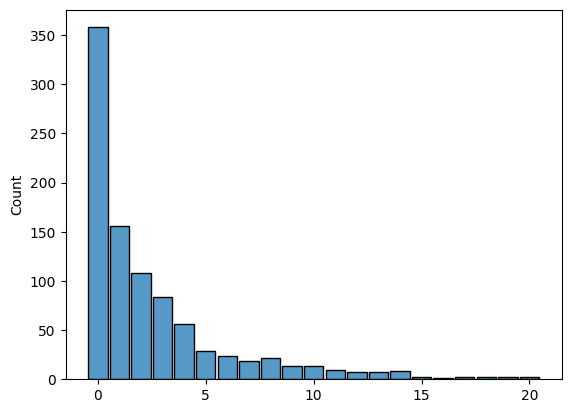

In [70]:
sns.histplot(x=ranks, discrete=True, binrange=(0,20), shrink=0.9)

In [71]:
ranks_zp=[]
for _case in tqdm(sub_df.index):
    probsarr = posteriors_dict_test[_case]['Full posterior']
    evs_nosplit = Analysis.evidence(probsarr, len(extlaws_dict_test), z_grid_test, split_laws=False)
    sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
    sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
    sorted_evs.reverse()

    mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Template SED'])[0][0]
    for idust, d in enumerate(dust_arr_test):
        if d.name==sub_df.loc[_case, 'Extinction law'] and d.EBV==sub_df.loc[_case, 'E(B-V)'] : dust_num = idust
    z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
    found=[t==mod_num and d==dust_num for (t,d) in sorted_evs]
    ranks_zp.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_zp, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 954/954 [08:27<00:00,  1.88it/s]


### Rank of $min(\chi^2)$ model in terms of $z_{spec}$

In [72]:
ranks_at_zs=[]
for _case in tqdm(sub_df.index):
    if jnp.isfinite(sub_df.loc[_case, 'True redshift']):
        zs=sub_df.loc[_case, 'True redshift']
        probsarr = posteriors_dict_test[_case]['Full posterior']
        if len(extlaws_dict_test)==1 and len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_noDust(probsarr, zs, len(baseTemp_arr_test), z_grid_test,\
                                                                  renormalize=True, prenormalize=False)
        elif len(extlaws_dict_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneLaw(probsarr, zs, len(baseTemp_arr_test),\
                                                                  ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        elif len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneEBV(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                                  z_grid_test, renormalize=True, prenormalize=False)
        else:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                           ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
        sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
        sorted_pzfix.reverse()
        
        mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Template SED'])[0][0]
        for idust, d in enumerate(dust_arr_test):
            if d.name==sub_df.loc[_case, 'Extinction law'] and d.EBV==sub_df.loc[_case, 'E(B-V)'] : dust_num = idust
        z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
        found=[t==mod_num and d==dust_num for (t,d) in sorted_pzfix]
        ranks_at_zs.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_at_zs, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 954/954 [10:31<00:00,  1.51it/s]  


In [73]:
ranks_ev_at_zs=[]
for _case in tqdm(sub_df.index):
    if jnp.isfinite(sub_df.loc[_case, 'True redshift']):
        zs=sub_df.loc[_case, 'True redshift']
        probsarr = posteriors_dict_test[_case]['Full posterior']
        if len(extlaws_dict_test)==1 and len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_noDust(probsarr, zs, len(baseTemp_arr_test), z_grid_test,\
                                                                  renormalize=True, prenormalize=False)
        elif len(extlaws_dict_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneLaw(probsarr, zs, len(baseTemp_arr_test),\
                                                                  ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        elif len(ebv_vals_test)==1:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z_oneEBV(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                                  z_grid_test, renormalize=True, prenormalize=False)
        else:
            p_zfix_nosplit, _n = Analysis.probs_at_fixed_z(probsarr, zs, len(baseTemp_arr_test), len(extlaws_dict_test),\
                                                           ebv_vals_test, z_grid_test, renormalize=True, prenormalize=False)
        sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
        sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
        sorted_pzfix.reverse()
        
        mod_num=np.argwhere(temp_names == sub_df.loc[_case, 'Highest evidence SED'])[0][0]
        for idust, d in enumerate(dust_arr_test):
            if d.name==sub_df.loc[_case, 'Highest evidence dust law'] and d.EBV==sub_df.loc[_case, 'Highest evidence E(B-V)'] : dust_num = idust
        z_num = np.argwhere(np.abs(z_grid_test-sub_df.loc[_case, 'Photometric redshift'])<test_inputs['Z_GRID']['z_step']/10)[0][0]
    
        found=[t==mod_num and d==dust_num for (t,d) in sorted_pzfix]
        ranks_ev_at_zs.append(np.argwhere(found)[0][0])
    
#sns.histplot(x=ranks_ev_at_zs, discrete=True, binrange=(0,20), shrink=0.9)

100%|██████████| 954/954 [08:38<00:00,  1.84it/s]


In [74]:
sub_df['photo-z model ranking at z_spec']=np.array(ranks_at_zs)

/tmp/ipykernel_679/2852833274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['photo-z model ranking at z_spec']=np.array(ranks_at_zs)


<AxesSubplot:xlabel='photo-z model ranking at z_spec', ylabel='Count'>

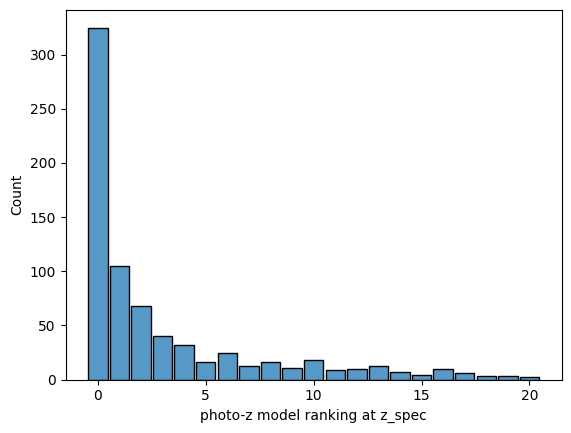

In [75]:
sns.histplot(data=sub_df, x='photo-z model ranking at z_spec', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

/tmp/ipykernel_679/1501437297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Highest evidence model ranking at z_spec']=np.array(ranks_ev_at_zs)


<AxesSubplot:xlabel='Highest evidence model ranking at z_spec', ylabel='Count'>

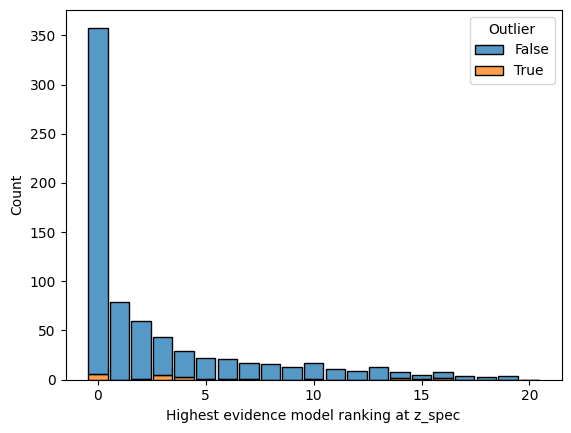

In [76]:
sub_df['Highest evidence model ranking at z_spec']=np.array(ranks_ev_at_zs)
sns.histplot(data=sub_df, x='Highest evidence model ranking at z_spec', hue='Outlier', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

<AxesSubplot:ylabel='Count'>

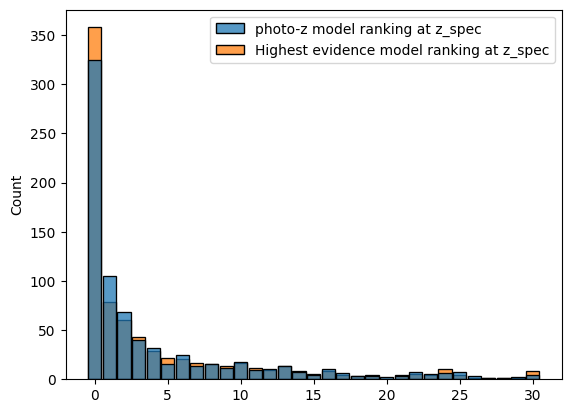

In [77]:
f,a=plt.subplots(1,1)
plot_df = sub_df[['photo-z model ranking at z_spec', 'Highest evidence model ranking at z_spec']].copy()
sns.histplot(data=plot_df, discrete=True, binrange=(0,30), shrink=0.9, multiple='dodge', ax=a, element='bars', cumulative=False)

/tmp/ipykernel_679/3333230702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Ranking of best model at z_spec']=np.array(ranks)


<AxesSubplot:xlabel='Ranking of best model at z_spec', ylabel='Count'>

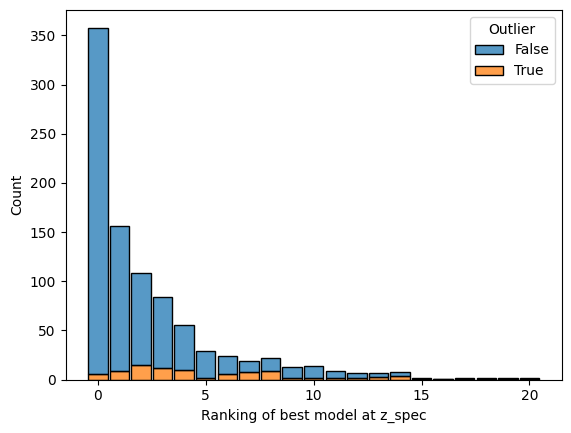

In [78]:
sub_df['Ranking of best model at z_spec']=np.array(ranks)
sns.histplot(data=sub_df, x='Ranking of best model at z_spec', hue='Outlier', discrete=True, binrange=(0,20), shrink=0.9, multiple='stack')

In [79]:
from pysankey import sankey

In [80]:
sub_df.columns

Index(['Id', 'Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'Highest evidence SED',
       'Highest evidence dust law', 'Highest evidence E(B-V)',
       'Highest evidence odd ratio', 'Highest evidence z_phot (mode)',
       'Highest evidence z_phot (mean)', 'Highest evidence sigma(z)',
       'Best SED at z_spec', 'Best dust law at z_spec', 'E(B-V) at z_spec',
       'Mode of best model at z_spec', 'Mean of best model at z_spec',
       'Odd ratio of best model at z_spec', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'Bias', 'Outlier', 'U-B',
       'R-I', 'Best estimator', 'Best point estimate',
       'Best estimator at z_spec', 'Best

In [81]:
if True:
    _t1 = ["FORS2-"+t.split('-')[-1] for t in sub_df['Template SED'].values]
    _t2 = ["FORS2-"+t.split('-')[-1] for t in sub_df['Highest evidence SED'].values]
    _t3 = ["FORS2-"+t.split('-')[-1] for t in sub_df['Best SED at z_spec'].values]

    sub_df['Template SED'] = _t1
    sub_df['Highest evidence SED'] = _t2
    sub_df['Best SED at z_spec'] = _t3

/tmp/ipykernel_679/1012285704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Template SED'] = _t1
/tmp/ipykernel_679/1012285704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Highest evidence SED'] = _t2
/tmp/ipykernel_679/1012285704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

<AxesSubplot:>

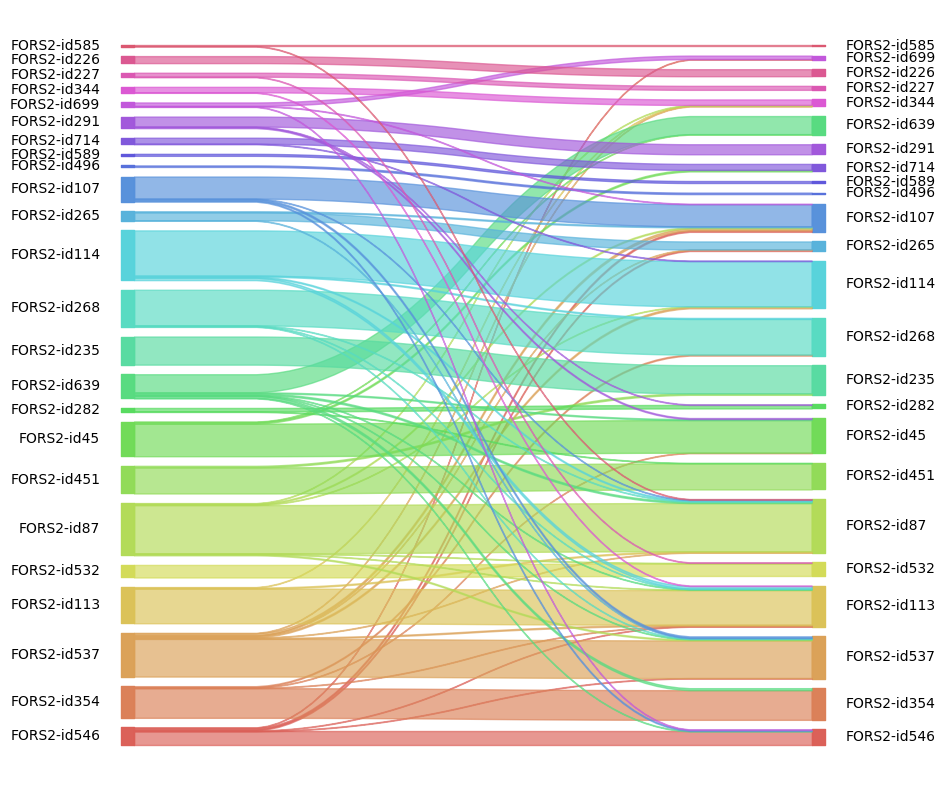

In [82]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(sub_df['Template SED'], sub_df['Highest evidence SED'], fontsize=10, ax=a)

<AxesSubplot:>

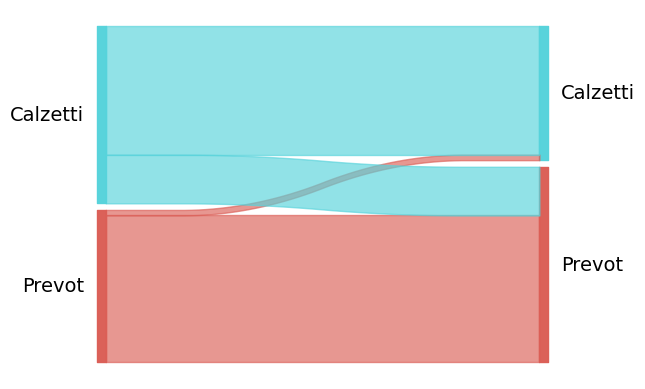

In [83]:
sankey(sub_df['Extinction law'], sub_df['Highest evidence dust law'])

<AxesSubplot:>

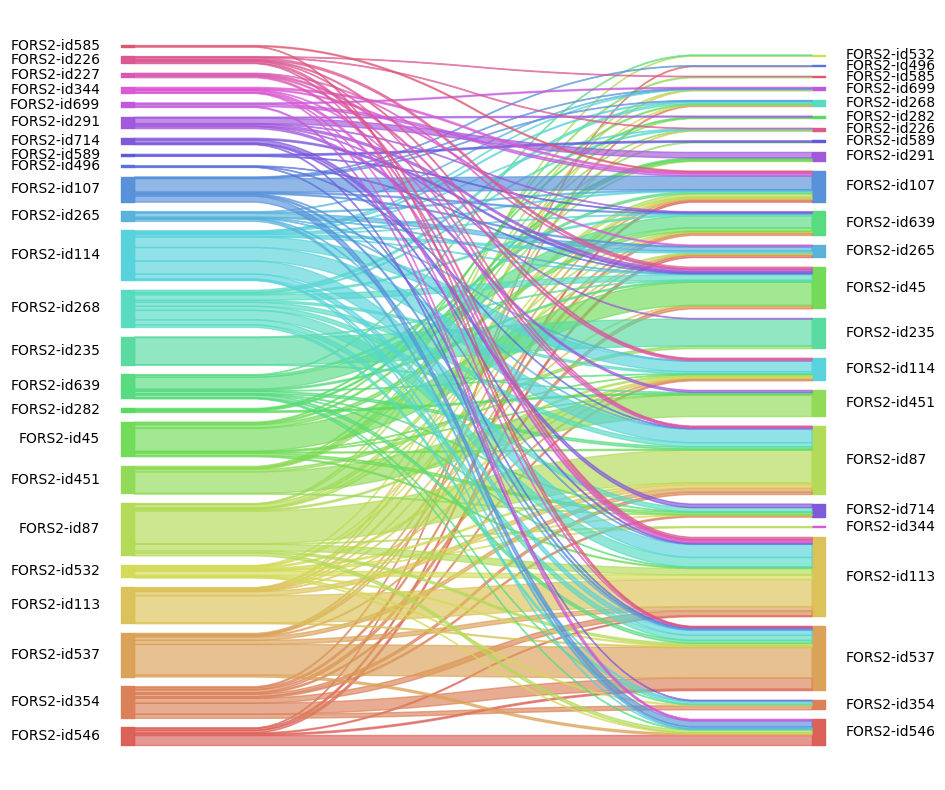

In [84]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(sub_df['Template SED'], sub_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

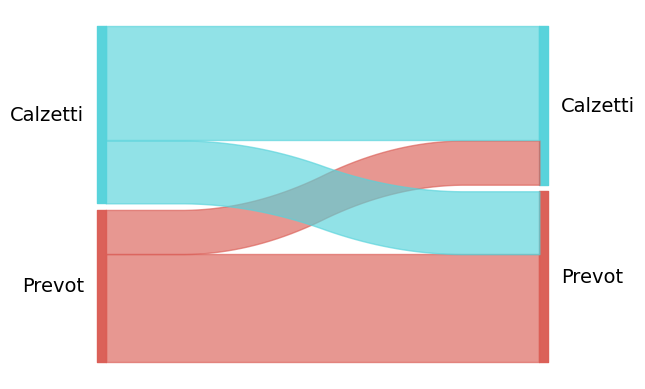

In [85]:
sankey(sub_df['Extinction law'], sub_df['Best dust law at z_spec'])

<AxesSubplot:>

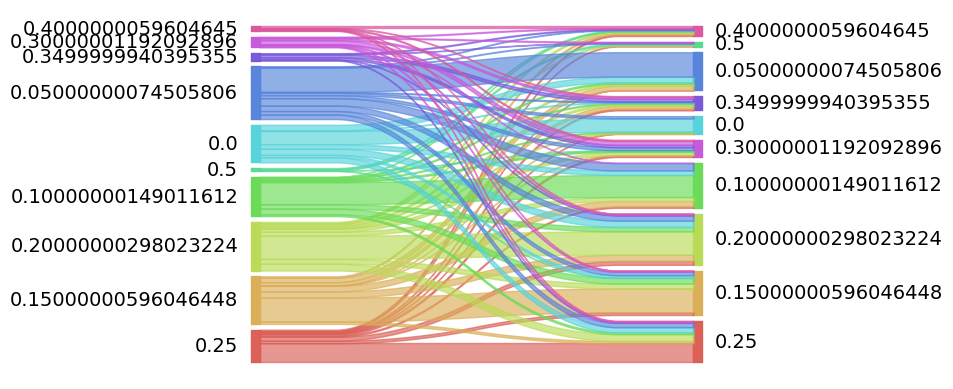

In [86]:
sankey(sub_df['E(B-V)'], sub_df['E(B-V) at z_spec'])

<AxesSubplot:>

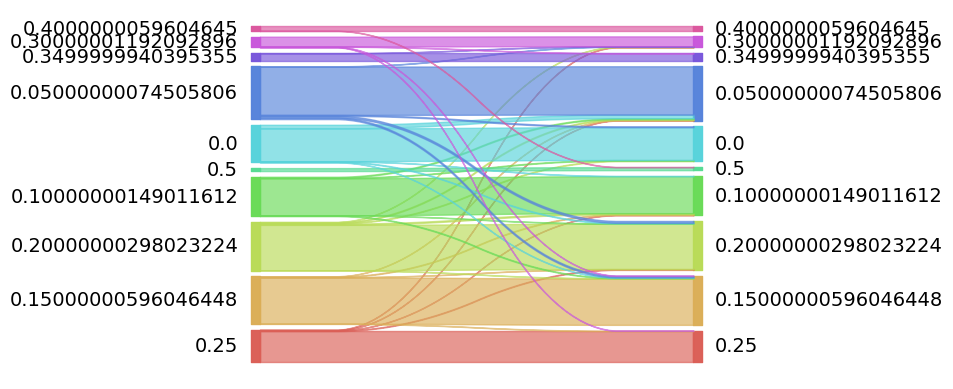

In [87]:
sankey(sub_df['E(B-V)'], sub_df['Highest evidence E(B-V)'])

<AxesSubplot:>

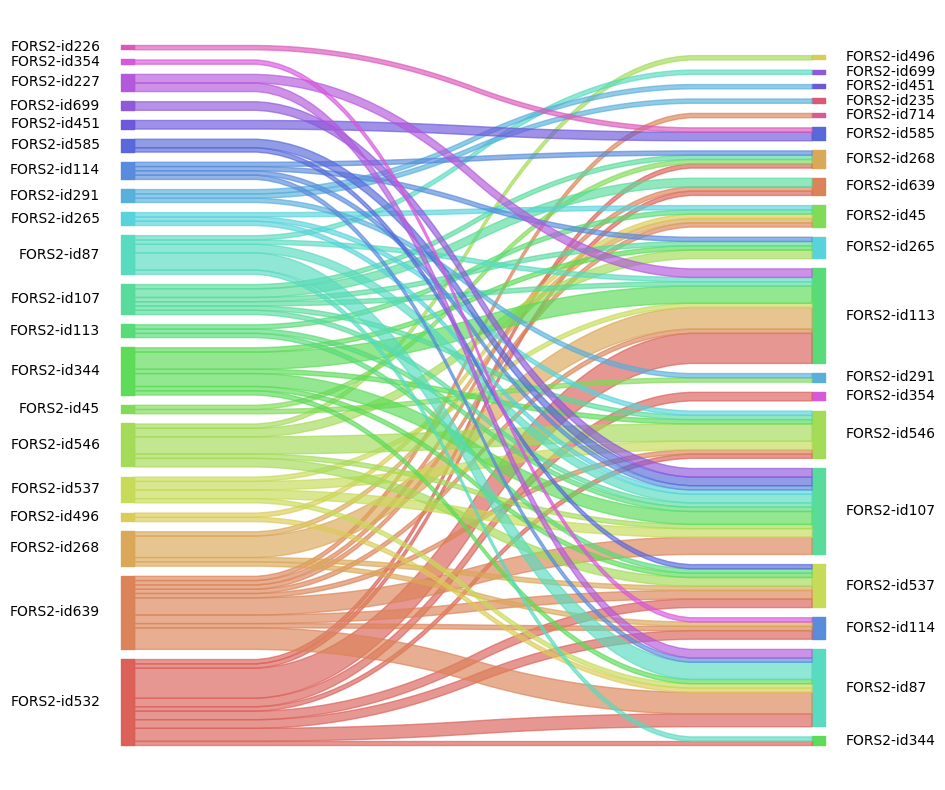

In [88]:
outliers_df = sub_df[sub_df['Outlier']]
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(outliers_df['Template SED'], outliers_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

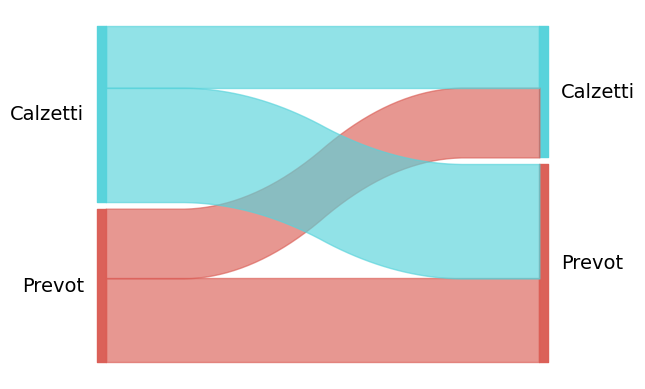

In [89]:
sankey(outliers_df['Extinction law'], outliers_df['Best dust law at z_spec'])

<AxesSubplot:>

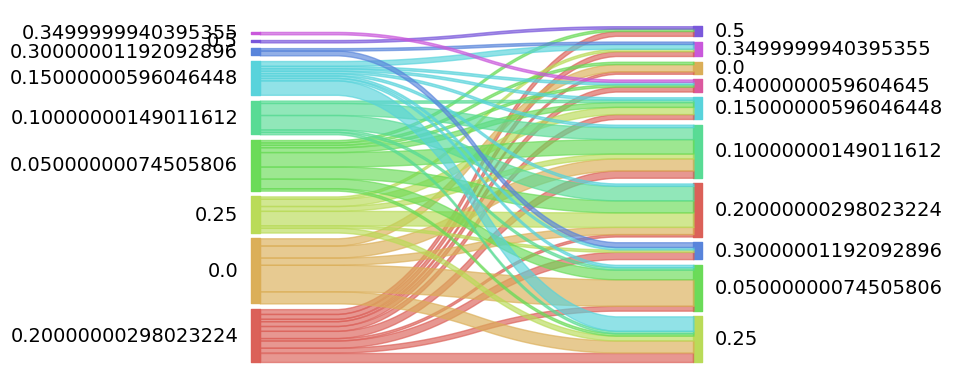

In [90]:
sankey(outliers_df['E(B-V)'], outliers_df['E(B-V) at z_spec'])

<AxesSubplot:>

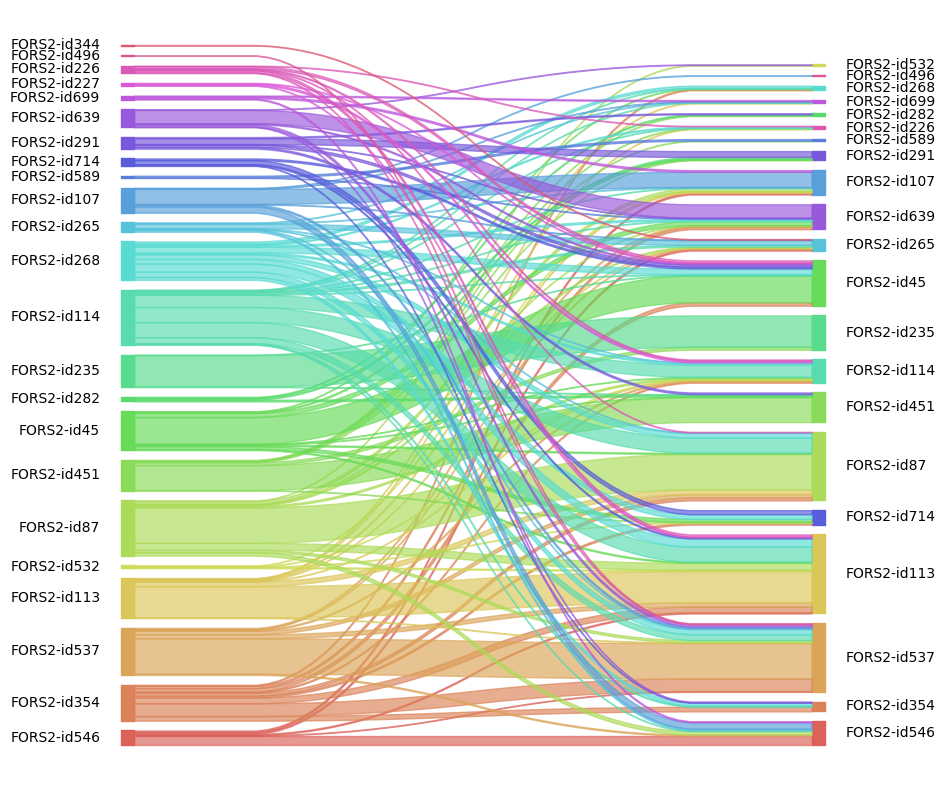

In [91]:
insiders_df = sub_df[[not b for b in sub_df['Outlier']]]
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(insiders_df['Template SED'], insiders_df['Best SED at z_spec'], fontsize=10, ax=a)

<AxesSubplot:>

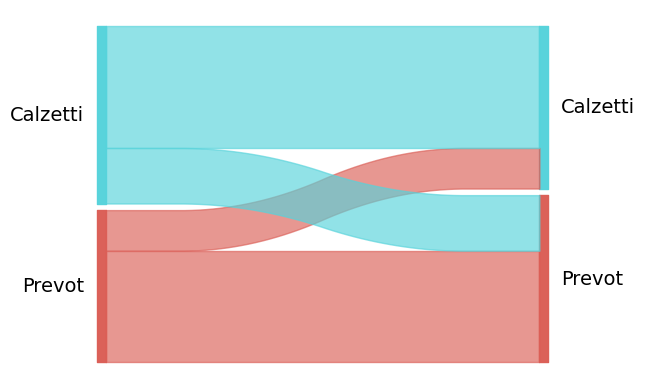

In [92]:
sankey(insiders_df['Extinction law'], insiders_df['Best dust law at z_spec'])

<AxesSubplot:>

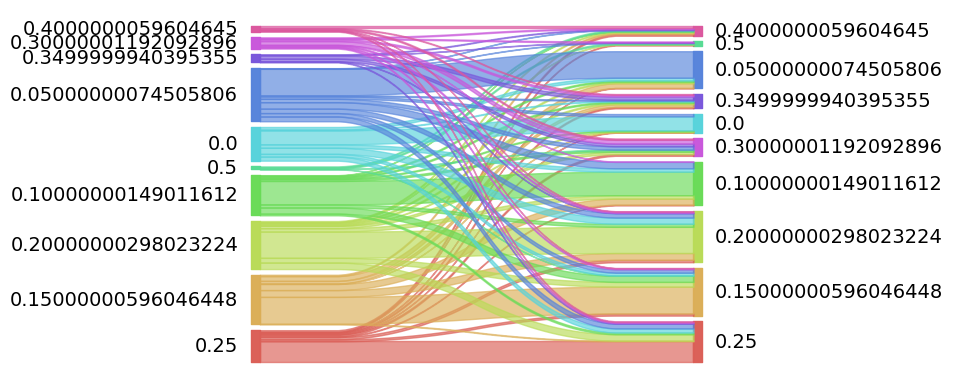

In [93]:
sankey(insiders_df['E(B-V)'], insiders_df['E(B-V) at z_spec'])

Pas de conclusion à propos de E(B-V) ni loi de poussière, par contre certaines templates peuvent être exclues par ce genre de procédé car très peu présentes dans les bons modèles à z_spec 